In [1]:
import torch
import numpy as np
import pandas as pd
import pickle
import statistics
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import significantdigits as sd
from significantdigits import Error
import re
import json
from matplotlib.lines import Line2D
import nibabel as nib
from nilearn import plotting
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime, timedelta


## Runtime

In [2]:
#Verrou failed to complete post processing of FastSurfer brain slices so we only count how long actual model segmentation took across methods

def extract_inference_time(filepath):
    seconds_list = []
    with open(filepath, "r") as file:
        for line in file:
            match = re.search(r'finished in ([\d.]+) seconds', line)
            if match:
                seconds = float(match.group(1))
                seconds_list.append(seconds)

    # return sum(seconds_list)/(24*60**2) #days
    return sum(seconds_list) #seconds

ieee_fastsurfer = []
verrou_sr_fastsurfer = []
verrou_ud_fastsurfer = []
fuzzy_sr_fastsurfer = []
fuzzy_ud_fastsurfer = []

for sub in range(1,6):
    tmp_v_sr = []
    tmp_v_ud = []
    tmp_f_ud = []
    tmp_f_sr = []
    tmp_ieee = []
    for iter in range(1,6):
        tmp_ieee.append(extract_inference_time(f'/home/inesgp/verrou_fastsurfer/slurm/ieee_fastsurfer_{sub}_{iter}.log'))
        tmp_v_sr.append(extract_inference_time(f'/home/inesgp/verrou_fastsurfer/runtime/verrou_sr_{sub}_{iter}.log'))
        tmp_v_ud.append(extract_inference_time(f'/home/inesgp/verrou_fastsurfer/runtime/verrou_ud_{sub}_{iter}.log'))
        # tmp_f_sr.append(extract_inference_time(f'/home/inesgp/verrou_fastsurfer/slurm/fuzzy_sr_dynamic_fastsurfer_{sub}_{iter}.out'))
        # tmp_f_ud.append(extract_inference_time(f'/home/inesgp/verrou_fastsurfer/slurm/fuzzy_ud_fastsurfer_v3_{sub}_{iter}.out'))
        tmp_f_sr.append(extract_inference_time(f'/home/inesgp/verrou_fastsurfer/slurm/fuzzy_sr_blacklist_fastsurfer_{sub}_{iter}.log'))
        tmp_f_ud.append(extract_inference_time(f'/home/inesgp/verrou_fastsurfer/slurm/fuzzy_ud_blacklist_fastsurfer_{sub}_{iter}.log'))

    ieee_fastsurfer.append(tmp_ieee)
    verrou_sr_fastsurfer.append(tmp_v_sr)
    verrou_ud_fastsurfer.append(tmp_v_ud)
    fuzzy_sr_fastsurfer.append(tmp_f_sr)
    fuzzy_ud_fastsurfer.append(tmp_f_ud)

verrou_sr_fastsurfer = np.array(verrou_sr_fastsurfer).mean(0)
verrou_ud_fastsurfer = np.array(verrou_ud_fastsurfer).mean(0)
fuzzy_sr_fastsurfer = np.array(fuzzy_sr_fastsurfer).mean(0)
fuzzy_ud_fastsurfer = np.array(fuzzy_ud_fastsurfer).mean(0)
ieee_fastsurfer = np.array(ieee_fastsurfer).mean(0)

verrou_ud_ratio = [(v/f) for v,f in zip(verrou_ud_fastsurfer, fuzzy_ud_fastsurfer)]
verrou_sr_ratio = [(v/f) for v,f in zip(verrou_sr_fastsurfer, fuzzy_sr_fastsurfer)]


fastsurfer_runtime = pd.DataFrame({'Default': ieee_fastsurfer, 'Verrou CESTAC': verrou_ud_fastsurfer, 'Fuzzy PyTorch UD': fuzzy_ud_fastsurfer, 
                                   'Verrou SR': verrou_sr_fastsurfer, 'Fuzzy PyTorch SR': fuzzy_sr_fastsurfer,
                              "Fuzzy UD Speed Up Factor from Verrou": verrou_ud_ratio, "Fuzzy SR Speed Up Factor from Verrou": verrou_sr_ratio, })
fastsurfer_runtime = fastsurfer_runtime.rename(index={0: 'MCA Iteration 1', 1: 'MCA Iteration 2', 2: 'MCA Iteration 3', 3: 'MCA Iteration 4', 4: 'MCA Iteration 5'})

fastsurfer_runtime



Default  Verrou CESTAC  Fuzzy PyTorch UD     Verrou SR  \
MCA Iteration 1   8319.70440   1.912558e+06       33730.45028  1.803795e+06   
MCA Iteration 2   8132.57106   1.913030e+06       32700.72016  1.765003e+06   
MCA Iteration 3   8375.73634   1.911201e+06       33134.19232  1.763066e+06   
MCA Iteration 4  14822.46296   1.913409e+06       37946.75530  1.740288e+06   
MCA Iteration 5   4929.04104   1.911560e+06       24248.70084  1.739391e+06   

                 Fuzzy PyTorch SR  Fuzzy UD Speed Up Factor from Verrou  \
MCA Iteration 1       38477.06072                             56.701215   
MCA Iteration 2       37286.76292                             58.501151   
MCA Iteration 3       38060.51288                             57.680613   
MCA Iteration 4       38306.01772                             50.423515   
MCA Iteration 5       29289.96574                             78.831432   

                 Fuzzy SR Speed Up Factor from Verrou  
MCA Iteration 1                             46.879759  
MCA Iteration 2                             47.335913  
MCA Iteration 3                             46.322712  
MCA Iteration 4                             45.431203  
MCA Iteration 5                             59.385210

In [4]:
for i in fastsurfer_runtime.columns:
    # print(i, np.mean(fastsurfer_runtime[i]), np.std(fastsurfer_runtime[i]))
    print(i, np.mean(fastsurfer_runtime[i]), )

Default 8915.903159999998
Verrou CESTAC 1912351.2829359998
Fuzzy PyTorch UD 32352.163780000003
Verrou SR 1762308.7441
Fuzzy PyTorch SR 36284.063996
Fuzzy UD Speed Up Factor from Verrou 60.42758527336973
Fuzzy SR Speed Up Factor from Verrou 49.07095946307852


In [5]:
# MNIST

# fuzzy_mnist = [] # fuzzy UD multithread
fuzzy_singlethread_ud_mnist = []
fuzzy_singlethread_sr_mnist = []
verrou_ud_mnist = []
verrou_sr_mnist = []
default_mnist = []

for num in range(1,6):
    # f = open(f"/home/inesgp/mnist/slurm/fuzzy_mnist_test_{num}.out")
    # for line in f: 
    #     if "real" in line:
    #         time_str = line.split('real')[-1]
    #         minutes, seconds = time_str.split('m')
    #         seconds = float(seconds.replace('s', ''))
    #         total_seconds = int(minutes) * 60 + seconds
    #         fuzzy_mnist.append(total_seconds)

    # f = open(f"/home/inesgp/mnist/slurm/fuzzy_mnist_test_singlethread_{num}.out")
    f = open(f"/home/inesgp/mnist/slurm/fuzzy_mnist_test_ud_v2_{num}.out")
    for line in f: 
        if "real" in line:
            time_str = line.split('real')[-1]
            minutes, seconds = time_str.split('m')
            seconds = float(seconds.replace('s', ''))
            total_seconds = int(minutes) * 60 + seconds
            fuzzy_singlethread_ud_mnist.append(total_seconds)
    
    # f = open(f"/home/inesgp/mnist/slurm/fuzzy_mnist_test_v2_{num}.out")
    f = open(f"/home/inesgp/mnist/slurm/fuzzy_mnist_test_sr_v2_{num}.out")
    for line in f: 
        if "real" in line:
            time_str = line.split('real')[-1]
            minutes, seconds = time_str.split('m')
            seconds = float(seconds.replace('s', ''))
            total_seconds = int(minutes) * 60 + seconds
            fuzzy_singlethread_sr_mnist.append(total_seconds)

    f = open(f"/home/inesgp/mnist/slurm/verrou_ud_trace_mnist_test_{num}.out")
    for line in f: 
        if "real" in line:
            time_str = line.split('real')[-1]
            minutes, seconds = time_str.split('m')
            seconds = float(seconds.replace('s', ''))
            total_seconds = int(minutes) * 60 + seconds
            verrou_ud_mnist.append(total_seconds)

    f = open(f"/home/inesgp/mnist/slurm/verrou_sr_trace_mnist_test_{num}.out")
    for line in f: 
        if "real" in line:
            time_str = line.split('real')[-1]
            minutes, seconds = time_str.split('m')
            seconds = float(seconds.replace('s', ''))
            total_seconds = int(minutes) * 60 + seconds
            verrou_sr_mnist.append(total_seconds)


    f = open(f"/home/inesgp/mnist/slurm/default_mnist_test_{num}.out")
    for line in f: 
        if "real" in line:
            time_str = line.split('real')[-1]
            minutes, seconds = time_str.split('m')
            seconds = float(seconds.replace('s', ''))
            total_seconds = int(minutes) * 60 + seconds
            default_mnist.append(total_seconds)

verrou_ud_ratio_singlethread = [(v/f) for v,f in zip(verrou_ud_mnist, fuzzy_singlethread_ud_mnist)]
verrou_sr_ratio_singlethread = [(v/f) for v,f in zip(verrou_sr_mnist, fuzzy_singlethread_sr_mnist)]
# fuzzy_ratio = [(d/f) for f,d in zip(fuzzy_rr_mnist, default_mnist)]

mnist_runtime = pd.DataFrame({'Default': default_mnist,'Verrou UD': verrou_ud_mnist, 'Verrou SR': verrou_sr_mnist, 'Fuzzy UD PyTorch': fuzzy_singlethread_ud_mnist, 'Fuzzy SR PyTorch': fuzzy_singlethread_sr_mnist, 
                              "Fuzzy UD Speed Up Factor from Verrou": verrou_ud_ratio_singlethread, "Fuzzy SR Speed Up Factor from Verrou": verrou_sr_ratio_singlethread, })
mnist_runtime = mnist_runtime.rename(index={0: 'MCA Iteration 1', 1: 'MCA Iteration 2', 2: 'MCA Iteration 3', 3: 'MCA Iteration 4', 4: 'MCA Iteration 5'})

print('Only observing single threaded results')
# print('Average Speed Up Factor: ',mnist_runtime['Speed Up Factor'].mean())
mnist_runtime

Only observing single threaded results


Default  Verrou UD  Verrou SR  Fuzzy UD PyTorch  \
MCA Iteration 1   14.004   4722.666   4801.143           111.055   
MCA Iteration 2   14.016   4278.724   4817.184           109.861   
MCA Iteration 3   14.013   4276.504   4813.450           114.310   
MCA Iteration 4   14.008   4258.391   4960.544           109.212   
MCA Iteration 5   13.999   4267.812   4095.451           111.640   

                 Fuzzy SR PyTorch  Fuzzy UD Speed Up Factor from Verrou  \
MCA Iteration 1           153.719                             42.525469   
MCA Iteration 2           154.028                             38.946705   
MCA Iteration 3           153.532                             37.411460   
MCA Iteration 4           152.537                             38.991970   
MCA Iteration 5           147.899                             38.228341   

                 Fuzzy SR Speed Up Factor from Verrou  
MCA Iteration 1                             31.233244  
MCA Iteration 2                             31.274729  
MCA Iteration 3                             31.351445  
MCA Iteration 4                             32.520267  
MCA Iteration 5                             27.690863

In [6]:
for i in mnist_runtime.columns:
    print(i, np.mean(mnist_runtime[i]), np.std(mnist_runtime[i]))

Default 14.008 0.006099180272790644
Verrou UD 4360.8194 181.06554442587924
Verrou SR 4697.554400000001 306.64822299997104
Fuzzy UD PyTorch 111.2156 1.7680821926596075
Fuzzy SR PyTorch 152.343 2.2774149380382975
Fuzzy UD Speed Up Factor from Verrou 39.22078913046307 1.7496866240930535
Fuzzy SR Speed Up Factor from Verrou 30.814109653854008 1.633536885178929


## MNIST Variability

**MCA -- 10 Iterations**

### Metric Analysis

In [22]:
def compile_results(dir_name, ):
    pred = {}
    target = {} 
    output = {}
    loss = {}
    for num in range(1,6):
    
        res = pickle.load(open(f'{dir_name}/test_metrics_{num}.pkl', 'rb'))
        # res = pickle.load(open('mnist_results_full/mnist_results_1.pkl', 'rb'))
    
        tmp_pred = torch.tensor([])
        tmp_target = torch.tensor([])
        tmp_output = torch.tensor([])
        tmp_loss = []
        
        for i in res.keys():
            for k in res[i]:
                # print(k)
                if i == 'pred': tmp_pred = torch.cat((tmp_pred, k))
                elif i == 'target': tmp_target = torch.cat((tmp_target, k))
                elif i == 'output': tmp_output = torch.cat((tmp_output, k))
                elif i == 'loss': tmp_loss.append(k)
    
        # print(tmp_output.shape)
        pred[num] = tmp_pred.numpy() 
        target[num] = tmp_target.numpy() 
        output[num] = tmp_output.numpy() 
        loss[num] = tmp_loss

    return pred, target, output, loss

def metric_unstability(pred, target, loss, macro=True):

    #gotten from slurm output
    #TODO save to file
    # avg_loss = [0.025298748701810838, 0.025298750564455987, 0.025298746135830878, 0.02529873021543026, 0.025298738285899163, 
    #         0.025298739501833915, 0.02529874346256256, 0.02529875337779522, 0.025298740258812905, 0.0252987517952919]

    acc = []
    macro_f1 = []
    weighted_f1 = []
    macro_precision = []
    weighted_precision = []
    macro_recall = []
    weighted_recall = []
    
    for i, j in zip(target, pred):
        acc.append(accuracy_score(target[i], pred[j]))
        macro_f1.append(f1_score(target[i], pred[j], average='macro'))
        weighted_f1.append(f1_score(target[i], pred[j], average='weighted'))
        macro_precision.append(precision_score(target[i], pred[j], average='macro'))
        weighted_precision.append(precision_score(target[i], pred[j], average='weighted'))
        macro_recall.append(recall_score(target[i], pred[j], average='macro'))
        weighted_recall.append(recall_score(target[i], pred[j], average='weighted'))
    
    # results = {'Accuracy': acc, 'Macro F1': macro_f1, 'Macro Precision': macro_precision, 'Macro Recall': macro_recall, 
    #            'Average Loss': avg_loss}
    
    if macro:
        results = {'Accuracy': acc, 'Macro F1': macro_f1, 'Weighted F1': weighted_f1, 'Macro Precision': macro_precision, 
                'Weighted Precision': weighted_precision, 'Macro Recall': macro_recall, 'Weighted Recall': weighted_recall, 
                'Average Loss per Batch': loss}
    else:
        results = {'Accuracy': acc, 'F1': weighted_f1, 'Precision': weighted_precision, 
                   'Recall': weighted_recall, 'Average Loss per Batch': loss}
        
    metrics = {}
    for m in results:
        if 'Average Loss per Batch' == m:
            metrics[m] = {'Mean': [np.mean(np.mean(np.array(list(loss.values())),axis=0))], 
                          'Standard Deviation': [np.mean(np.std(np.array(list(loss.values())),axis=0))],
                          'Significant Digits': [ np.mean( sd.significant_digits(np.array(list(loss.values()), dtype=np.float32), reference=np.mean(np.array(list(loss.values())), axis=0, dtype=np.float32),  basis=10, error=Error.Relative) ) ]  }
        else: metrics[m] = {'Mean': [statistics.mean(results[m])], 'Standard Deviation': [statistics.stdev(results[m])], 'Significant Digits': [sd.significant_digits(np.array(results[m], dtype=np.float32), reference=np.mean(results[m], dtype=np.float32),  basis=10, error=Error.Relative)] }


    if macro:

        df = pd.concat( [pd.DataFrame(metrics['Accuracy']), pd.DataFrame(metrics['Macro F1']), pd.DataFrame(metrics['Weighted F1']),
                    pd.DataFrame(metrics['Macro Precision']), pd.DataFrame(metrics['Weighted Precision']),
                    pd.DataFrame(metrics['Macro Recall']), pd.DataFrame(metrics['Weighted Recall']), 
                        pd.DataFrame(metrics['Average Loss per Batch'])] )
        
        df.index = ['Accuracy', 'Macro F1', 'Weighted F1', 'Macro Precision', 'Weighted Precision', 'Macro Recall', 'Weighted Recall',
                    'Average Loss\nper Batch'] 
    
    else:
        df = pd.concat( [pd.DataFrame(metrics['Accuracy']), pd.DataFrame(metrics['F1']),
                    pd.DataFrame(metrics['Precision']), pd.DataFrame(metrics['Recall']), pd.DataFrame(metrics['Average Loss per Batch'])] )
        
        df.index = ['Accuracy', 'F1', 'Precision', 'Recall', 'Average Loss<br>per Batch'] 
    
    # df.loc[df.index != "Average Loss per Batch", "Mean"] *= 100

    
    return df


In [23]:
default_pred, default_target, default_output, default_loss = compile_results('/home/inesgp/mnist/default', )
# fuzzy_pred, fuzzy_target, fuzzy_output, fuzzy_loss = compile_results('/home/inesgp/mnist/fuzzy', )
# fuzzy_ud_singlethread_pred, fuzzy_ud_singlethread_target, fuzzy_ud_singlethread_output, fuzzy_ud_singlethread_loss = compile_results('/home/inesgp/mnist/fuzzy_ud', )
fuzzy_ud_singlethread_pred, fuzzy_ud_singlethread_target, fuzzy_ud_singlethread_output, fuzzy_ud_singlethread_loss = compile_results('/home/inesgp/mnist/fuzzy_ud', ) 
# fuzzy_ud_static_pred, fuzzy_ud_static_target, fuzzy_ud_static_output, fuzzy_ud_static_loss = compile_results('/home/inesgp/mnist/fuzzy_ud_static', ) #original version
fuzzy_ud_static_pred, fuzzy_ud_static_target, fuzzy_ud_static_output, fuzzy_ud_static_loss = compile_results('/home/inesgp/mnist/fuzzy_ud_static_v2', )
fuzzy_sr_singlethread_pred, fuzzy_sr_singlethread_target, fuzzy_sr_singlethread_output, fuzzy_sr_singlethread_loss = compile_results('/home/inesgp/mnist/fuzzy_v2', )
fuzzy_sr_singlethread_pred, fuzzy_sr_singlethread_target, fuzzy_sr_singlethread_output, fuzzy_sr_singlethread_loss = compile_results('/home/inesgp/mnist/fuzzy_sr_static', )
# fuzzy_sr_dynamic_pred, fuzzy_sr_dynamic_target, fuzzy_sr_dynamic_output, fuzzy_sr_dynamic_loss = compile_results('/home/inesgp/mnist/fuzzy_sr_dynamic', )
verrou_ud_pred, verrou_ud_target, verrou_ud_output, verrou_ud_loss = compile_results('/home/inesgp/mnist/verrou_ud_trace', )
verrou_sr_pred, verrou_sr_target, verrou_sr_output, verrou_sr_loss = compile_results('/home/inesgp/mnist/verrou_sr_trace', )


# fuzzy_df = metric_unstability(fuzzy_pred, fuzzy_target, fuzzy_loss)
# fuzzy_ud_singlethread_df = metric_unstability(fuzzy_ud_singlethread_pred, fuzzy_ud_singlethread_target, fuzzy_ud_singlethread_loss)
fuzzy_ud_static_df = metric_unstability(fuzzy_ud_static_pred, fuzzy_ud_static_target, fuzzy_ud_static_loss, macro=False)
fuzzy_sr_singlethread_df = metric_unstability(fuzzy_sr_singlethread_pred, fuzzy_sr_singlethread_target, fuzzy_sr_singlethread_loss, macro=False)
# fuzzy_sr_dynamic_df = metric_unstability(fuzzy_sr_dynamic_pred, fuzzy_sr_dynamic_target, fuzzy_sr_dynamic_loss)
verrou_ud_df = metric_unstability(verrou_ud_pred, verrou_ud_target, verrou_ud_loss, macro=False)
verrou_sr_df = metric_unstability(verrou_sr_pred, verrou_sr_target, verrou_sr_loss, macro=False)
default_df = metric_unstability(default_pred, default_target, default_loss, macro=False)

In [61]:
default_df

Mean  Standard Deviation  Significant Digits
Accuracy                0.991400        0.000000e+00            6.173022
Macro F1                0.991323        0.000000e+00            6.173022
Weighted F1             0.991397        0.000000e+00            6.173022
Macro Precision         0.991361        0.000000e+00            6.173022
Weighted Precision      0.991408        0.000000e+00            6.173022
Macro Recall            0.991299        0.000000e+00            6.173022
Weighted Recall         0.991400        0.000000e+00            6.173022
Average Loss per Batch  0.026059        3.469447e-19            6.173022

In [60]:
verrou_ud_df

Mean  Standard Deviation  Significant Digits
Accuracy                0.991400        0.000000e+00            6.173022
Macro F1                0.991323        0.000000e+00            6.173022
Weighted F1             0.991397        0.000000e+00            6.173022
Macro Precision         0.991361        0.000000e+00            6.173022
Weighted Precision      0.991408        0.000000e+00            6.173022
Macro Recall            0.991299        0.000000e+00            6.173022
Weighted Recall         0.991400        0.000000e+00            6.173022
Average Loss per Batch  0.026059        4.847502e-09            5.788662

In [24]:
fig = go.Figure()

# Add bar traces for each data series
# fig.add_trace(go.Bar(
#     x=np.arange(len(fuzzy_ud_singlethread_df['Mean'])),
#     y=fuzzy_ud_singlethread_df['Significant Digits'],
#     name='Fuzzy UD v1',
#     marker=dict(
#         color=px.colors.qualitative.Plotly[0], 
#         pattern=dict(shape='/', fillmode='overlay', size=10)  # Diagonal lines
#     ),
# ))

fig.add_trace(go.Bar(
    x=np.arange(len(fuzzy_ud_static_df['Mean'])),
    y=fuzzy_ud_static_df['Significant Digits'],
    name='Fuzzy UD',
    marker=dict(
        color=px.colors.qualitative.Plotly[0], 
        pattern=dict(shape='/', fillmode='overlay', size=10)  # Diagonal lines
    ),
))


fig.add_trace(go.Bar(
    x=np.arange(len(verrou_ud_df['Mean'])),
    y=verrou_ud_df['Significant Digits'],
    name='Verrou CESTAC',
    marker=dict(
        color=px.colors.qualitative.Plotly[4], 
        pattern=dict(shape='/', fillmode='overlay', size=10)  # Diagonal lines
    ),
))

fig.add_trace(go.Bar(
    x=np.arange(len(fuzzy_sr_singlethread_df['Mean'])),
    y=fuzzy_sr_singlethread_df['Significant Digits'],
    name='Fuzzy SR',
    marker=dict(
        color=px.colors.qualitative.Plotly[0], 
    ),
))

# fig.add_trace(go.Bar(
#     x=np.arange(len(fuzzy_sr_dynamic_df['Mean'])),
#     y=fuzzy_sr_dynamic_df['Significant Digits'],
#     name='Fuzzy SR v2',
#     marker=dict(
#         color=px.colors.qualitative.Plotly[0], 
#     ),
# ))

fig.add_trace(go.Bar(
    x=np.arange(len(verrou_sr_df['Mean'])),
    y=verrou_sr_df['Significant Digits'],
    name='Verrou SR',
    marker=dict(
        color=px.colors.qualitative.Plotly[4], 
    ),
))

# fig.add_trace(go.Bar(
#     x=np.arange(len(default_df['Mean'])),
#     y=default_df['Significant Digits'],
#     name='IEEE'
# ))

# Set axis labels and layout
fig.update_layout(
    width=800,
    height=500,
    margin=dict(l=10, r=10, t=30, b=10),  # Tight margins
    xaxis=dict(
        title='Metrics',
        tickmode='array',
        tickvals=np.arange(len(default_df.index)),
        ticktext=list(default_df.index),
        tickangle=0
    ),
    yaxis=dict(
        title='Significant Digits',
        range=[5.0, 7.0]
    ),
    legend=dict(
        orientation='h',  
        yanchor='bottom',  
        xanchor='center',  
        y=1.0,             # Position the legend above the plot (slightly above the top y-axis)
        x=0.5              # Center the legend horizontally
    ),
    barmode='group',  # Grouped bar chart
    font=dict(size=20),
    # template="plotly_white"
)

# Save as PDF (requires Kaleido for offline export)
# fig.write_image('/home/inesgp/mnist/mnist_sig_metrics.pdf', engine="kaleido", format='pdf')
fig.write_image('/home/inesgp/mnist/mnist_sig_metrics.svg', engine="kaleido")

# Show the figure
fig.show()


In [7]:
fuzzy_ud_singlethread_df = metric_unstability(fuzzy_ud_singlethread_pred, fuzzy_ud_singlethread_target, fuzzy_ud_singlethread_loss)
fig = go.Figure()

# Add bar traces for each data series
fig.add_trace(go.Bar(
    x=np.arange(len(fuzzy_ud_singlethread_df['Mean'])),
    y=fuzzy_ud_singlethread_df['Significant Digits'],
    name='Fuzzy UD v1',
    marker=dict(
        color=px.colors.qualitative.Plotly[0], 
        pattern=dict(shape='/', fillmode='overlay', size=10)  # Diagonal lines
    ),
))

fig.add_trace(go.Bar(
    x=np.arange(len(fuzzy_ud_static_df['Mean'])),
    y=fuzzy_ud_static_df['Significant Digits'],
    name='Fuzzy UD v2',
    marker=dict(
        color=px.colors.qualitative.Plotly[0], 
        pattern=dict(shape='/', fillmode='overlay', size=10)  # Diagonal lines
    ),
))


fig.add_trace(go.Bar(
    x=np.arange(len(verrou_ud_df['Mean'])),
    y=verrou_ud_df['Significant Digits'],
    name='Verrou CESTAC',
    marker=dict(
        color=px.colors.qualitative.Plotly[4], 
        pattern=dict(shape='/', fillmode='overlay', size=10)  # Diagonal lines
    ),
))

fig.add_trace(go.Bar(
    x=np.arange(len(fuzzy_sr_singlethread_df['Mean'])),
    y=fuzzy_sr_singlethread_df['Significant Digits'],
    name='Fuzzy SR v1',
    marker=dict(
        color=px.colors.qualitative.Plotly[0], 
    ),
))

fig.add_trace(go.Bar(
    x=np.arange(len(fuzzy_sr_dynamic_df['Mean'])),
    y=fuzzy_sr_dynamic_df['Significant Digits'],
    name='Fuzzy SR v2',
    marker=dict(
        color=px.colors.qualitative.Plotly[0], 
    ),
))

fig.add_trace(go.Bar(
    x=np.arange(len(verrou_sr_df['Mean'])),
    y=verrou_sr_df['Significant Digits'],
    name='Verrou SR',
    marker=dict(
        color=px.colors.qualitative.Plotly[4], 
    ),
))

# fig.add_trace(go.Bar(
#     x=np.arange(len(default_df['Mean'])),
#     y=default_df['Significant Digits'],
#     name='IEEE'
# ))

# Set axis labels and layout
fig.update_layout(
    width=800,
    height=500,
    margin=dict(l=10, r=10, t=30, b=10),  # Tight margins
    xaxis=dict(
        title='Metrics',
        tickmode='array',
        tickvals=np.arange(len(default_df.index)),
        ticktext=list(default_df.index),
        tickangle=20
    ),
    yaxis=dict(
        title='Significant Digits',
        range=[5.0, 7.0]
    ),
    legend=dict(
        orientation='h',  
        yanchor='bottom',  
        xanchor='center',  
        y=1.0,             # Position the legend above the plot (slightly above the top y-axis)
        x=0.5              # Center the legend horizontally
    ),
    barmode='group',  # Grouped bar chart
    font=dict(size=13),
    # template="plotly_white"
)

# Save as PDF (requires Kaleido for offline export)
# fig.write_image('/home/inesgp/mnist/mnist_sig_metrics.pdf', engine="kaleido", format='pdf')

# Show the figure
fig.show()


### Embeddings

(32, 26, 26)
(64, 24, 24)


/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)


(64, 12, 12)


/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)


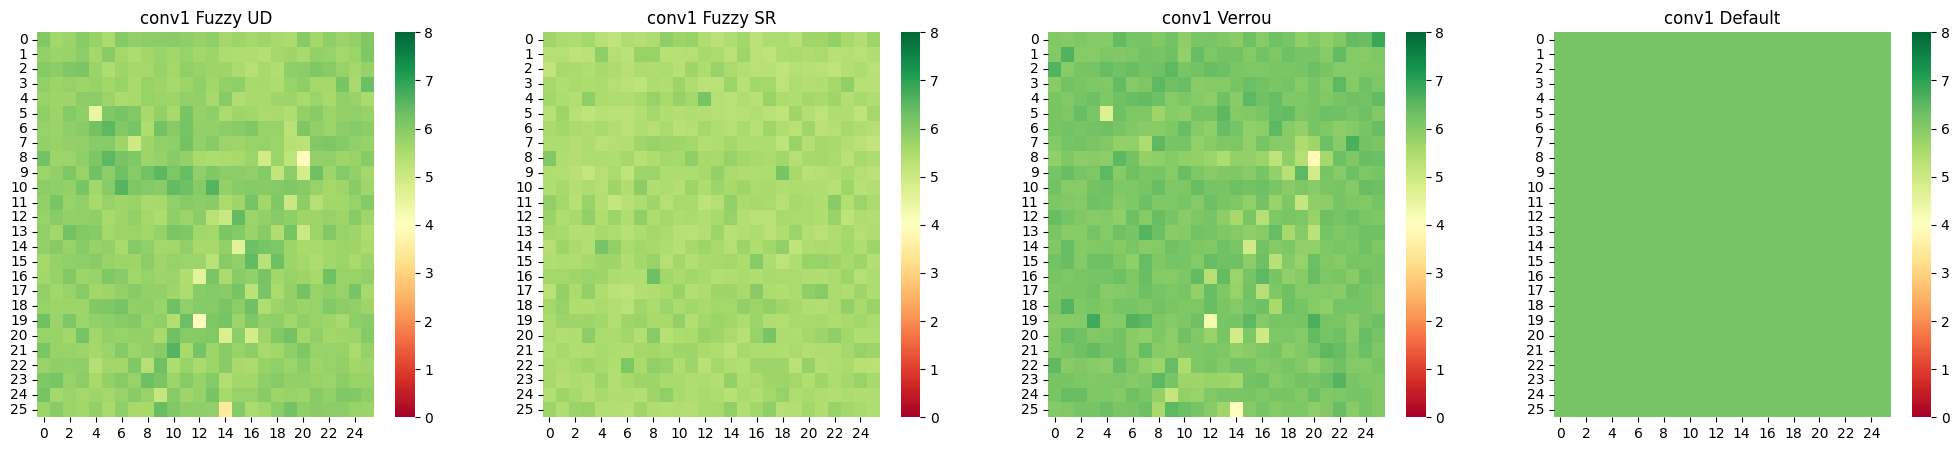

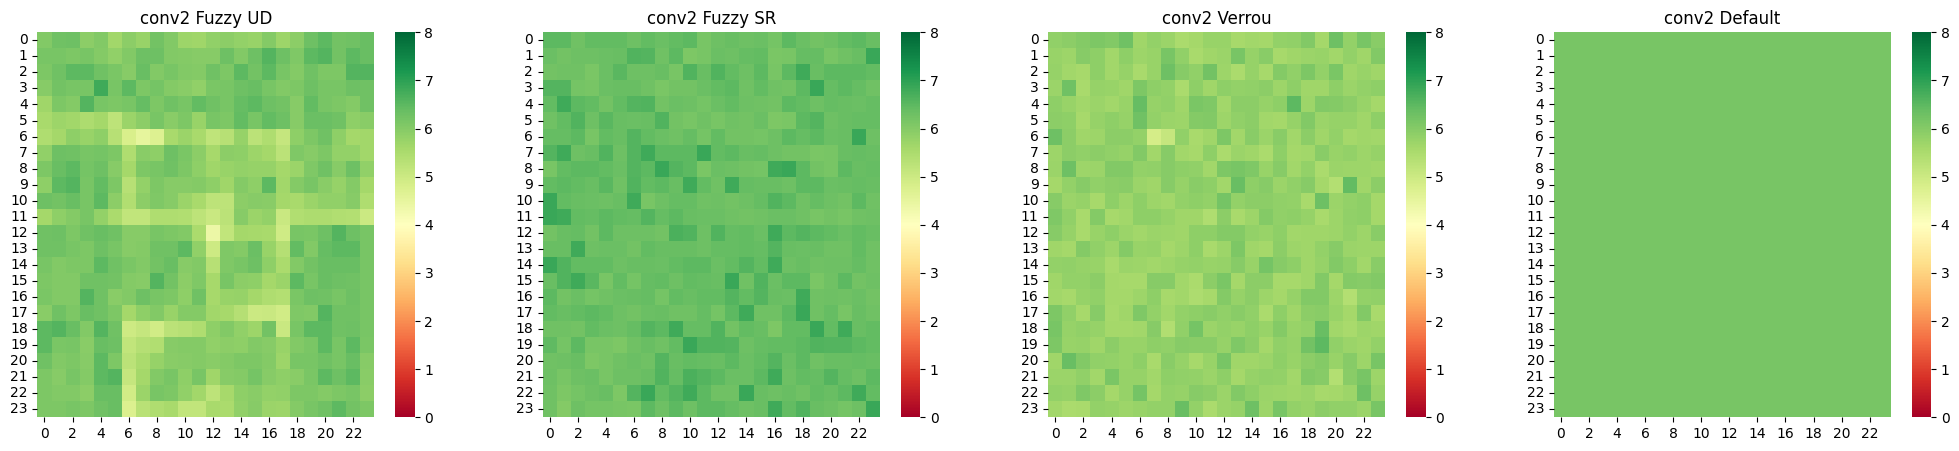

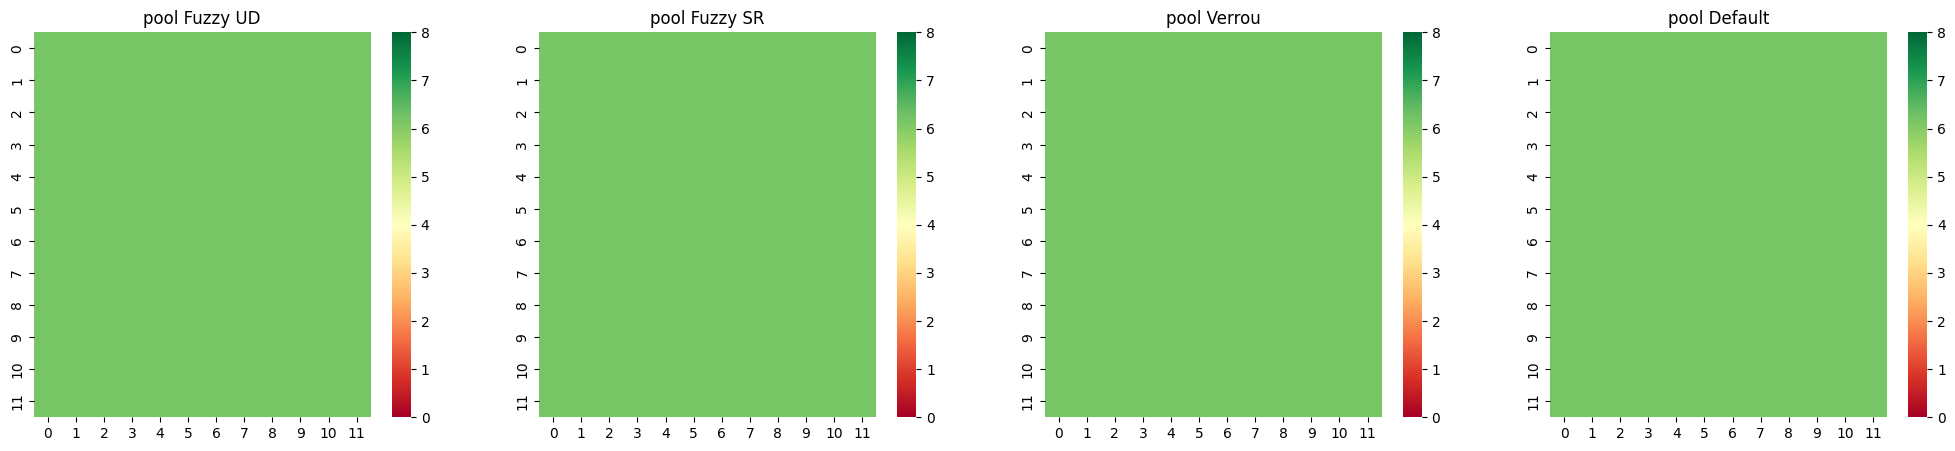

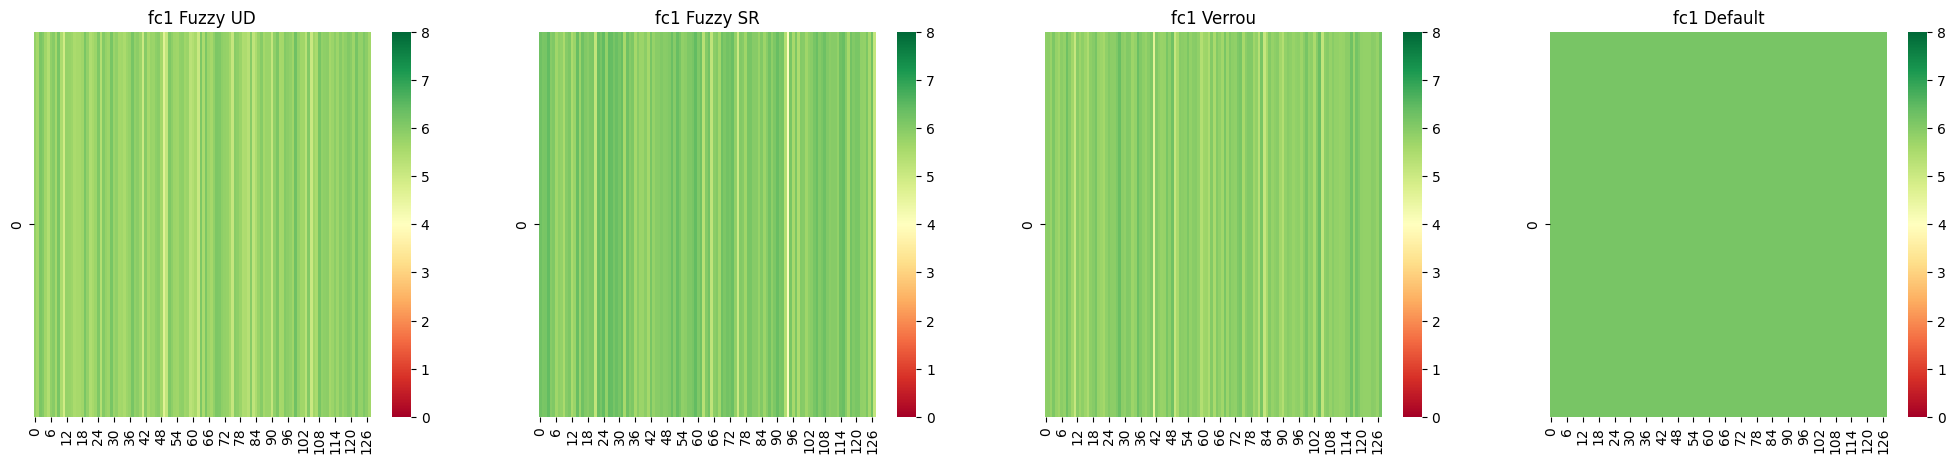

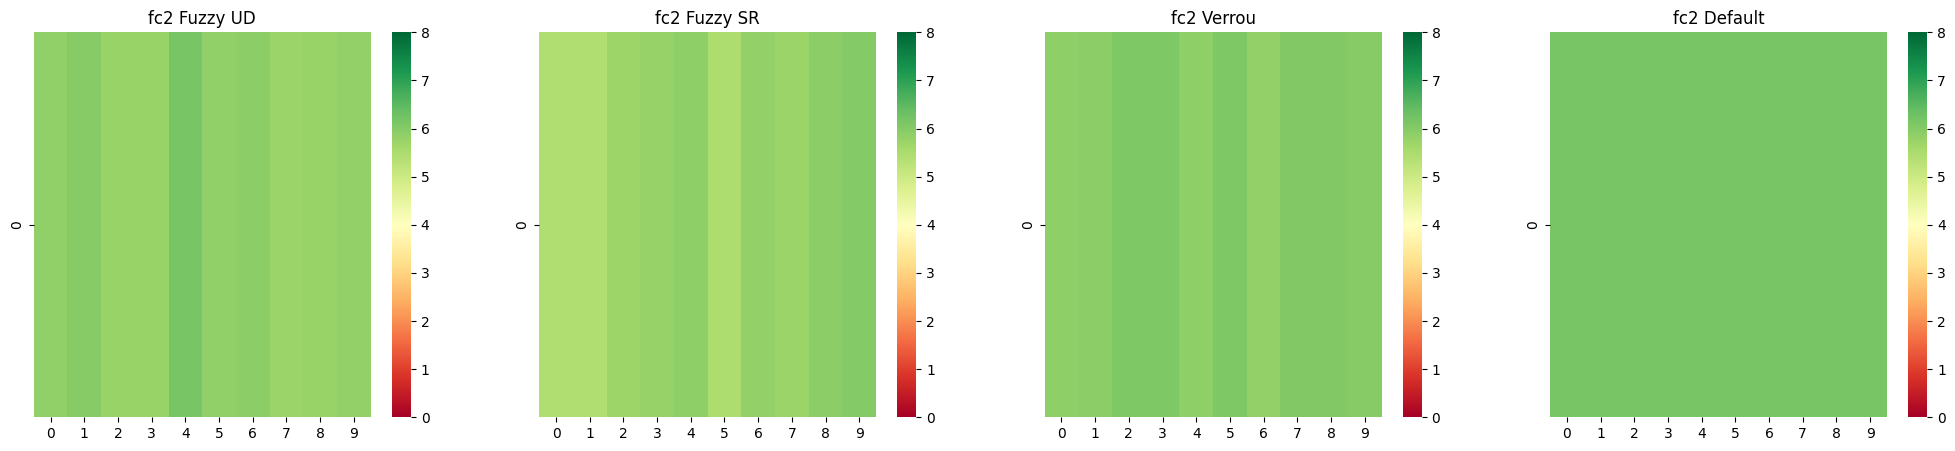

In [9]:

for layer in ['conv1', 'conv2', 'pool', 'fc1', 'fc2']:
# for layer in ['fc1', 'fc2']:
    embed_fuzzy_singlethread = []
    embed_fuzzy_multithread = []
    embed_verrou = []
    embed_default = []
    for i in range(1,6):
        embed_fuzzy_singlethread.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_ud/{layer}_{i}.pkl", 'rb'))[0] )
        embed_fuzzy_multithread.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_sr_dynamic/{layer}_{i}.pkl", 'rb'))[0] )
        embed_verrou.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/verrou/{layer}_{i}.pkl", 'rb'))[0] )
        embed_default.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/default/{layer}_{i}.pkl", 'rb'))[0] )
    embed_fuzzy_singlethread = torch.stack(embed_fuzzy_singlethread)
    embed_fuzzy_multithread = torch.stack(embed_fuzzy_multithread)
    embed_verrou = torch.stack(embed_verrou)
    embed_default = torch.stack(embed_default)

    fig, axes = plt.subplots(1,4, figsize=(25,5))

    if 'fc' in layer: 
        #fuzzy single threaded
        layer_sig = sd.significant_digits(embed_fuzzy_singlethread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_singlethread, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig.reshape(1,-1), ax=axes[0], cmap='RdYlGn', vmin=0, vmax=8)
        #fuzzy multithreaded
        layer_sig = sd.significant_digits(embed_fuzzy_multithread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_multithread, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig.reshape(1,-1), ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)
        #verrou
        layer_sig = sd.significant_digits(embed_verrou.type(dtype=torch.float32), reference=torch.mean(embed_verrou, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig.reshape(1,-1), ax=axes[2], cmap='RdYlGn', vmin=0, vmax=8)
        #IEEE
        layer_sig = sd.significant_digits(embed_default.type(dtype=torch.float32), reference=torch.mean(embed_default, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig.reshape(1,-1), ax=axes[3], cmap='RdYlGn', vmin=0, vmax=8)


    else:
        #fuzzy single threaded
        layer_sig = sd.significant_digits(embed_fuzzy_singlethread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_singlethread, dim=0, dtype=torch.float32),  basis=10)
        print(layer_sig.shape)
        sns.heatmap(layer_sig[0], ax=axes[0], cmap='RdYlGn', vmin=0, vmax=8)
        #fuzzy multi threaded
        layer_sig = sd.significant_digits(embed_fuzzy_multithread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_multithread, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig[0], ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)
        #verrou
        layer_sig = sd.significant_digits(embed_verrou.type(dtype=torch.float32), reference=torch.mean(embed_verrou, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig[0], ax=axes[2], cmap='RdYlGn', vmin=0, vmax=8)
        #IEEE
        layer_sig = sd.significant_digits(embed_default.type(dtype=torch.float32), reference=torch.mean(embed_default, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig[0], ax=axes[3], cmap='RdYlGn', vmin=0, vmax=8)

    axes[0].set_title(f"{layer} Fuzzy UD")
    axes[1].set_title(f"{layer} Fuzzy SR")
    axes[2].set_title(f"{layer} Verrou")
    axes[3].set_title(f"{layer} Default")
    

plt.show()

/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)


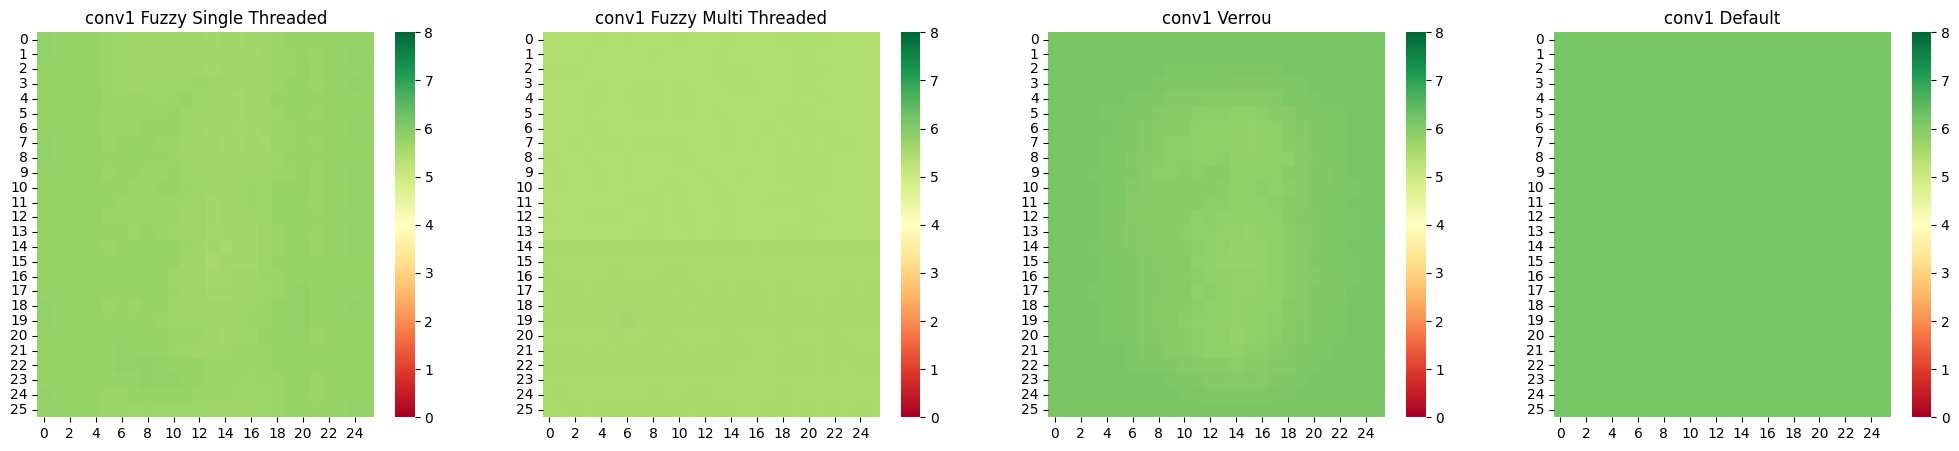

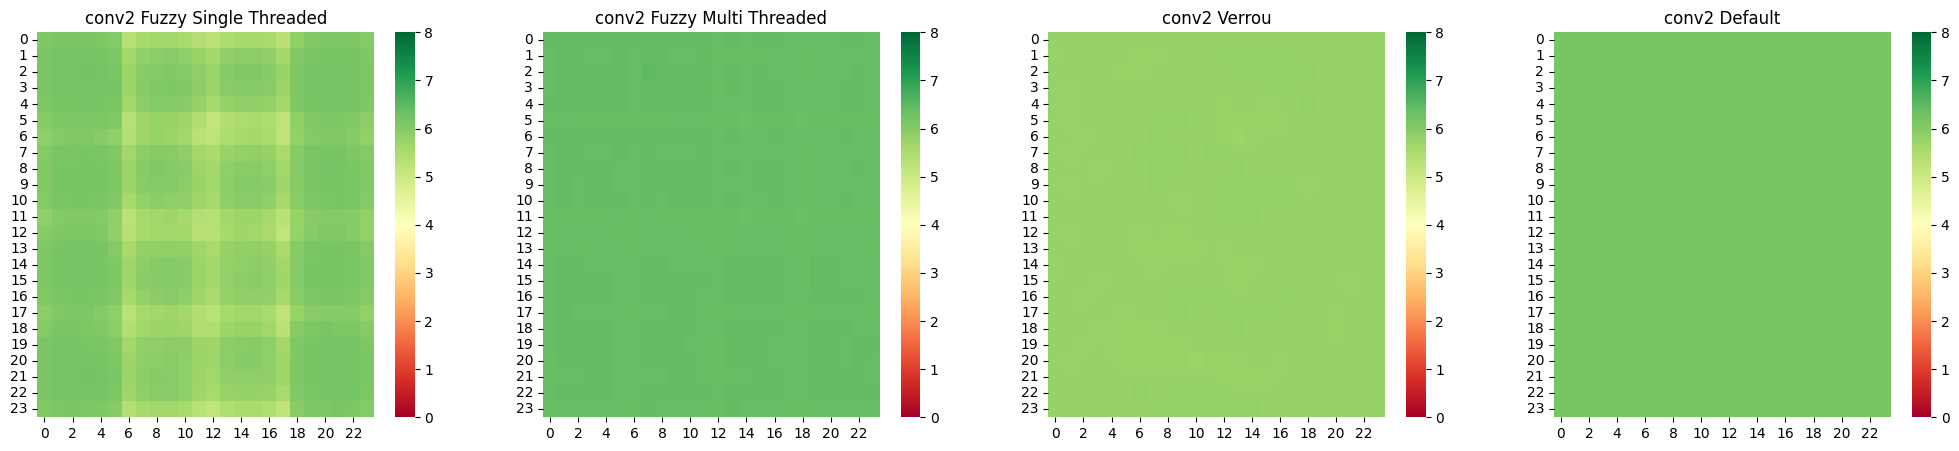

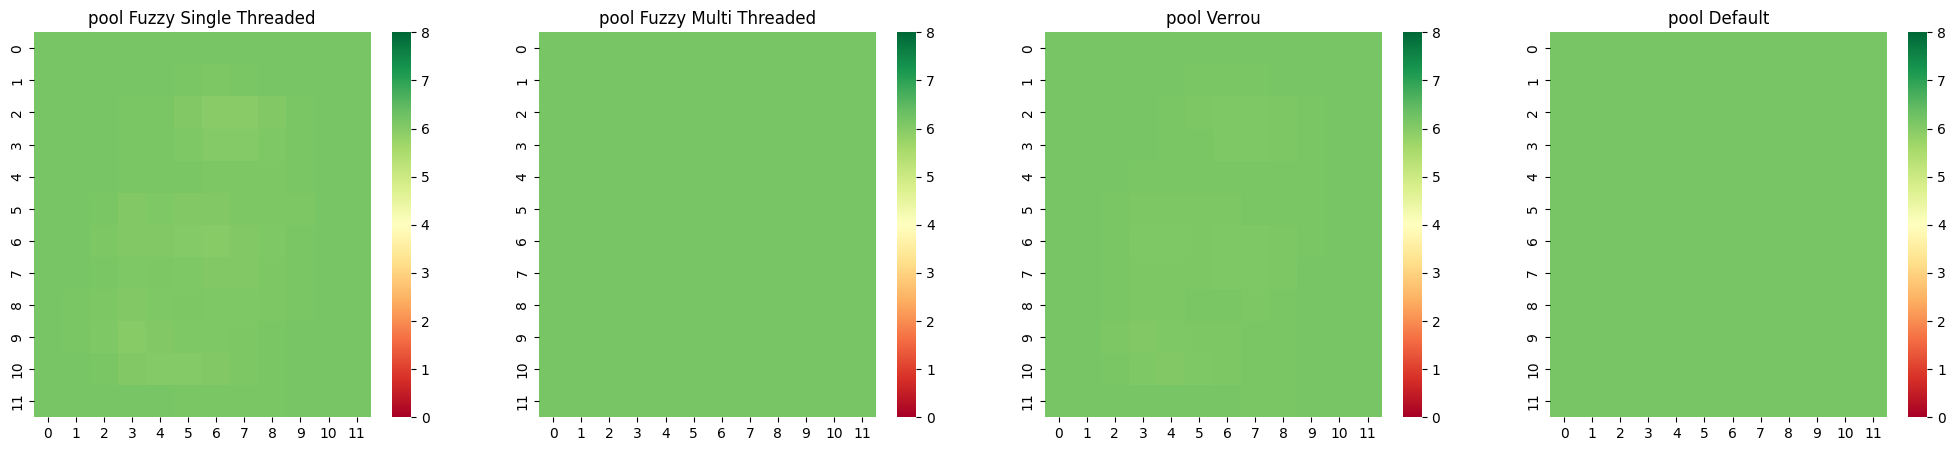

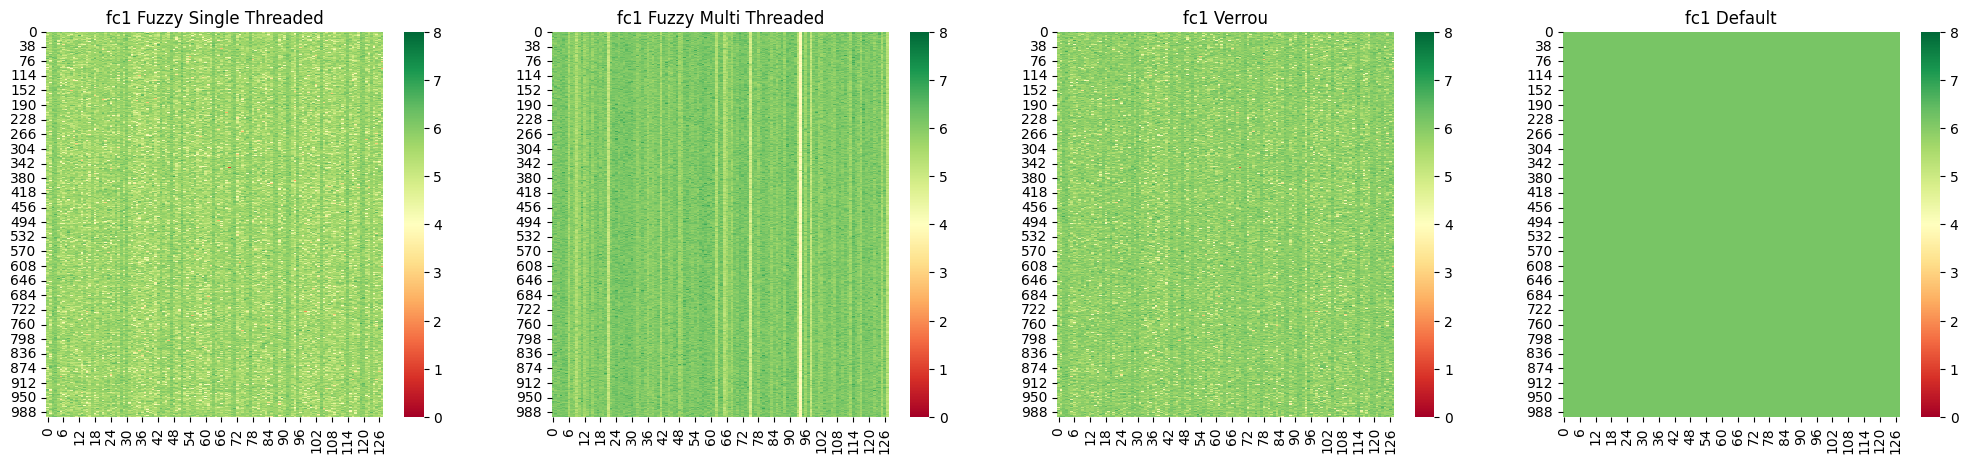

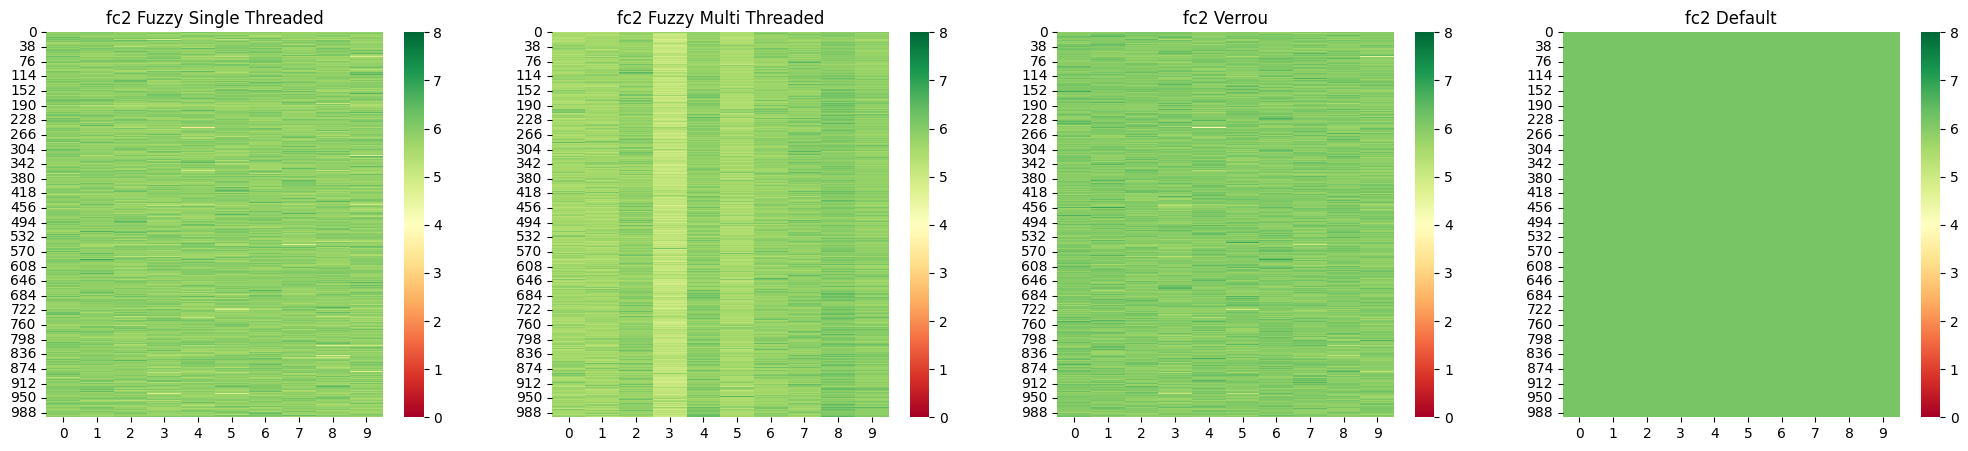

In [6]:

for layer in ['conv1', 'conv2', 'pool', 'fc1', 'fc2']:
# for layer in ['fc1', 'fc2']:
    embed_fuzzy_singlethread = []
    embed_fuzzy_multithread = []
    embed_verrou = []
    embed_default = []
    for i in range(1,6):
        embed_fuzzy_singlethread.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_ud/{layer}_{i}.pkl", 'rb')) )
        embed_fuzzy_multithread.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_sr_dynamic/{layer}_{i}.pkl", 'rb')) )
        embed_verrou.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/verrou/{layer}_{i}.pkl", 'rb')) )
        embed_default.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/default/{layer}_{i}.pkl", 'rb')) )
    embed_fuzzy_singlethread = torch.stack(embed_fuzzy_singlethread)
    embed_fuzzy_multithread = torch.stack(embed_fuzzy_multithread)
    embed_verrou = torch.stack(embed_verrou)
    embed_default = torch.stack(embed_default)

    fig, axes = plt.subplots(1,4, figsize=(25,5))

    if 'fc' in layer: 
        #fuzzy single threaded
        layer_sig = sd.significant_digits(embed_fuzzy_singlethread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_singlethread, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig, ax=axes[0], cmap='RdYlGn', vmin=0, vmax=8)
        #fuzzy multithreaded
        layer_sig = sd.significant_digits(embed_fuzzy_multithread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_multithread, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig, ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)
        #verrou
        layer_sig = sd.significant_digits(embed_verrou.type(dtype=torch.float32), reference=torch.mean(embed_verrou, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig, ax=axes[2], cmap='RdYlGn', vmin=0, vmax=8)
        #IEEE
        layer_sig = sd.significant_digits(embed_default.type(dtype=torch.float32), reference=torch.mean(embed_default, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig, ax=axes[3], cmap='RdYlGn', vmin=0, vmax=8)


    else:
        #fuzzy single threaded
        layer_sig = np.mean(sd.significant_digits(embed_fuzzy_singlethread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_singlethread, dim=0, dtype=torch.float32),  basis=10), axis=0, dtype=np.float32)
        sns.heatmap(layer_sig[0], ax=axes[0], cmap='RdYlGn', vmin=0, vmax=8)
        #fuzzy multi threaded
        layer_sig = np.mean(sd.significant_digits(embed_fuzzy_multithread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_multithread, dim=0, dtype=torch.float32),  basis=10), axis=0, dtype=np.float32)
        sns.heatmap(layer_sig[0], ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)
        #verrou
        layer_sig = np.mean(sd.significant_digits(embed_verrou.type(dtype=torch.float32), reference=torch.mean(embed_verrou, dim=0, dtype=torch.float32),  basis=10), axis=0, dtype=np.float32)
        sns.heatmap(layer_sig[0], ax=axes[2], cmap='RdYlGn', vmin=0, vmax=8)
        #IEEE
        layer_sig = np.mean(sd.significant_digits(embed_default.type(dtype=torch.float32), reference=torch.mean(embed_default, dim=0, dtype=torch.float32),  basis=10), axis=0, dtype=np.float32)
        sns.heatmap(layer_sig[0], ax=axes[3], cmap='RdYlGn', vmin=0, vmax=8)

    axes[0].set_title(f"{layer} Fuzzy UD")
    axes[1].set_title(f"{layer} Fuzzy SR")
    axes[2].set_title(f"{layer} Verrou")
    axes[3].set_title(f"{layer} Default")
    

plt.show()

#### Averaged Across Data Samples

/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)


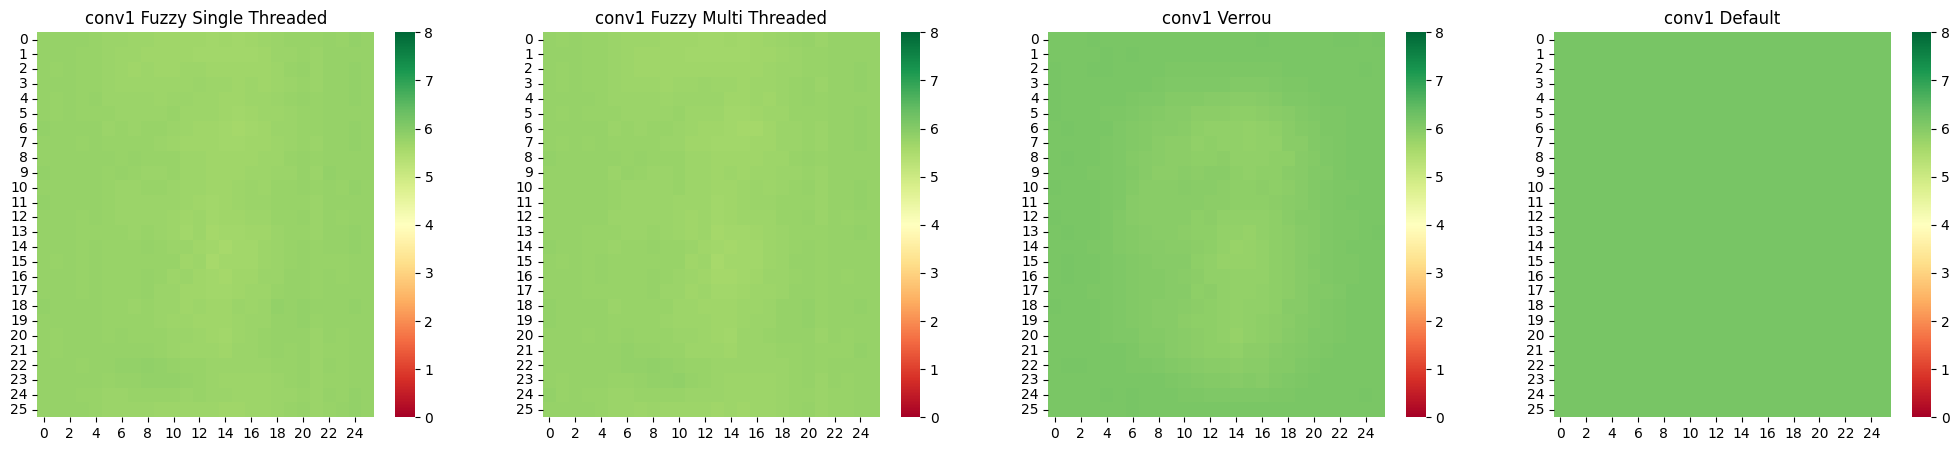

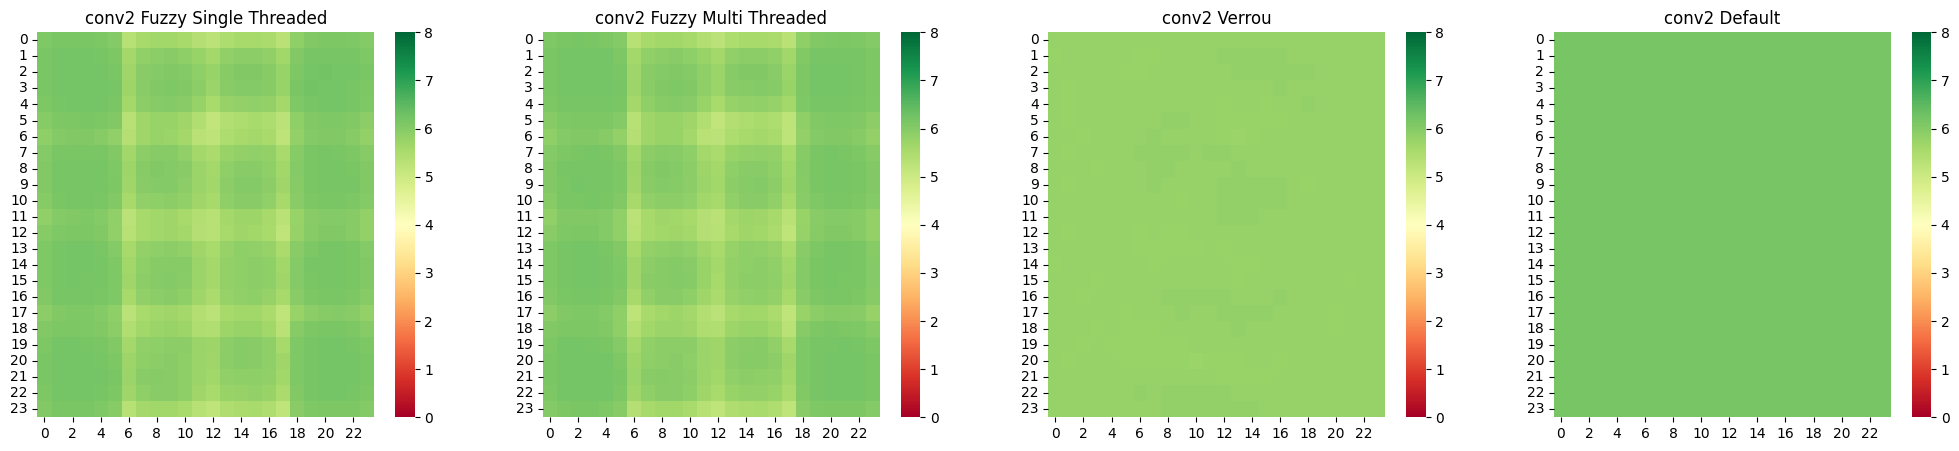

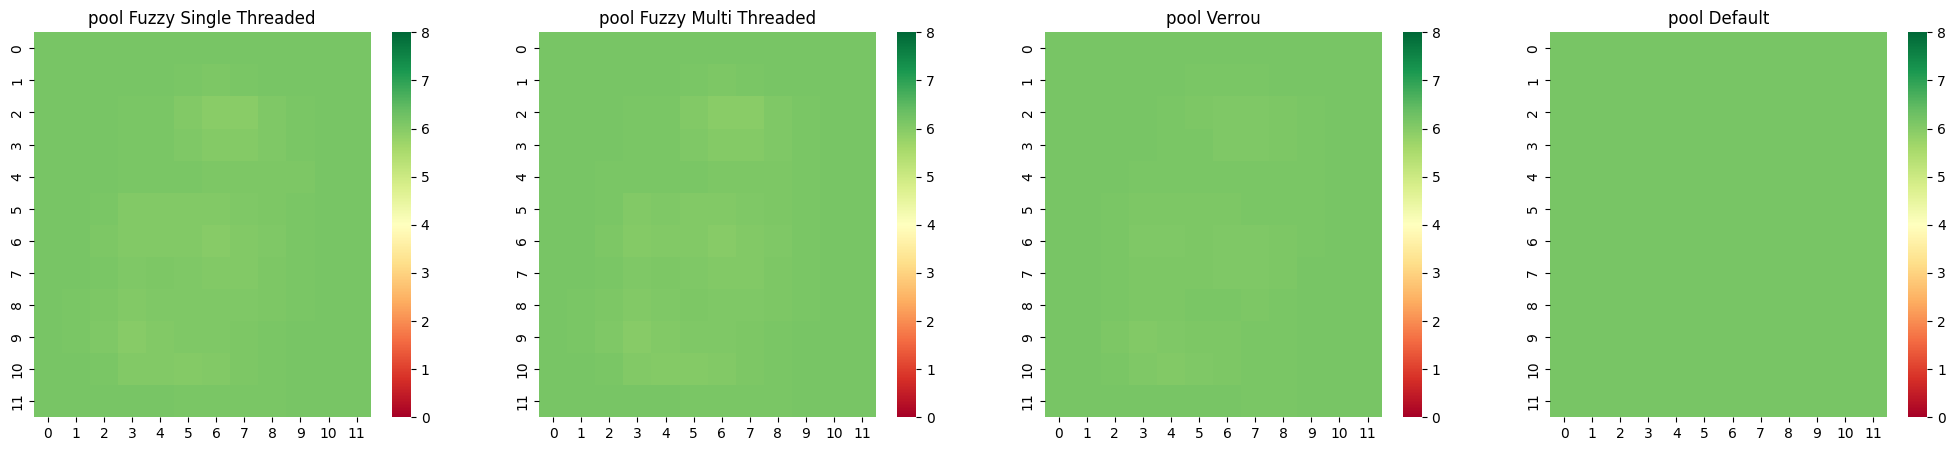

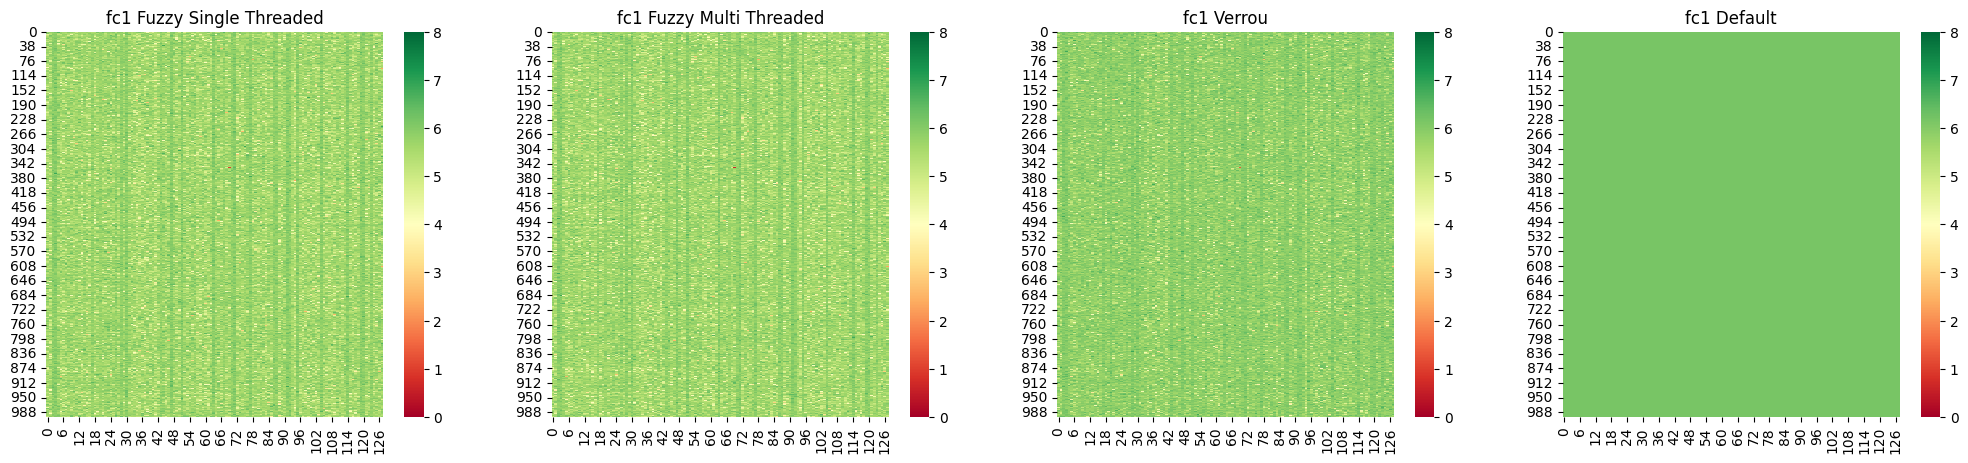

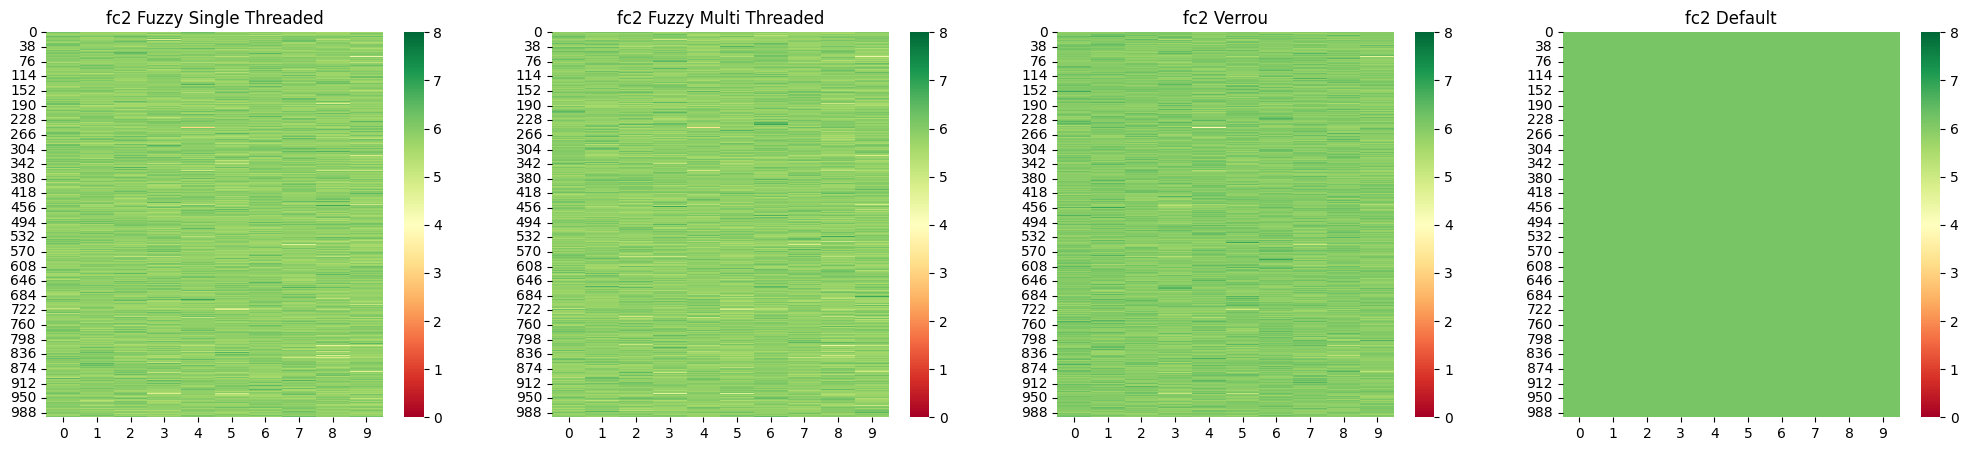

In [51]:

for layer in ['conv1', 'conv2', 'pool', 'fc1', 'fc2']:
# for layer in ['fc1', 'fc2']:
    embed_fuzzy_singlethread = []
    embed_fuzzy_multithread = []
    embed_verrou = []
    embed_default = []
    for i in range(1,6):
        embed_fuzzy_singlethread.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_ud/{layer}_{i}.pkl", 'rb')) )
        embed_fuzzy_multithread.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_multi/{layer}_{i}.pkl", 'rb')) )
        embed_verrou.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/verrou/{layer}_{i}.pkl", 'rb')) )
        embed_default.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/default/{layer}_{i}.pkl", 'rb')) )
    embed_fuzzy_singlethread = torch.stack(embed_fuzzy_singlethread)
    embed_fuzzy_multithread = torch.stack(embed_fuzzy_multithread)
    embed_verrou = torch.stack(embed_verrou)
    embed_default = torch.stack(embed_default)

    fig, axes = plt.subplots(1,4, figsize=(25,5))

    if 'fc' in layer: 
        #fuzzy single threaded
        layer_sig = sd.significant_digits(embed_fuzzy_singlethread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_singlethread, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig, ax=axes[0], cmap='RdYlGn', vmin=0, vmax=8)
        #fuzzy multithreaded
        layer_sig = sd.significant_digits(embed_fuzzy_multithread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_multithread, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig, ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)
        #verrou
        layer_sig = sd.significant_digits(embed_verrou.type(dtype=torch.float32), reference=torch.mean(embed_verrou, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig, ax=axes[2], cmap='RdYlGn', vmin=0, vmax=8)
        #IEEE
        layer_sig = sd.significant_digits(embed_default.type(dtype=torch.float32), reference=torch.mean(embed_default, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig, ax=axes[3], cmap='RdYlGn', vmin=0, vmax=8)


    else:
        #fuzzy single threaded
        layer_sig = np.mean(sd.significant_digits(embed_fuzzy_singlethread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_singlethread, dim=0, dtype=torch.float32),  basis=10), axis=0, dtype=np.float32)
        sns.heatmap(layer_sig[0], ax=axes[0], cmap='RdYlGn', vmin=0, vmax=8)
        #fuzzy multi threaded
        layer_sig = np.mean(sd.significant_digits(embed_fuzzy_multithread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_multithread, dim=0, dtype=torch.float32),  basis=10), axis=0, dtype=np.float32)
        sns.heatmap(layer_sig[0], ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)
        #verrou
        layer_sig = np.mean(sd.significant_digits(embed_verrou.type(dtype=torch.float32), reference=torch.mean(embed_verrou, dim=0, dtype=torch.float32),  basis=10), axis=0, dtype=np.float32)
        sns.heatmap(layer_sig[0], ax=axes[2], cmap='RdYlGn', vmin=0, vmax=8)
        #IEEE
        layer_sig = np.mean(sd.significant_digits(embed_default.type(dtype=torch.float32), reference=torch.mean(embed_default, dim=0, dtype=torch.float32),  basis=10), axis=0, dtype=np.float32)
        sns.heatmap(layer_sig[0], ax=axes[3], cmap='RdYlGn', vmin=0, vmax=8)

    axes[0].set_title(f"{layer} Fuzzy Single Threaded")
    axes[1].set_title(f"{layer} Fuzzy Multi Threaded")
    axes[2].set_title(f"{layer} Verrou")
    axes[3].set_title(f"{layer} Default")
    

plt.show()

#### Embeddings from Paper

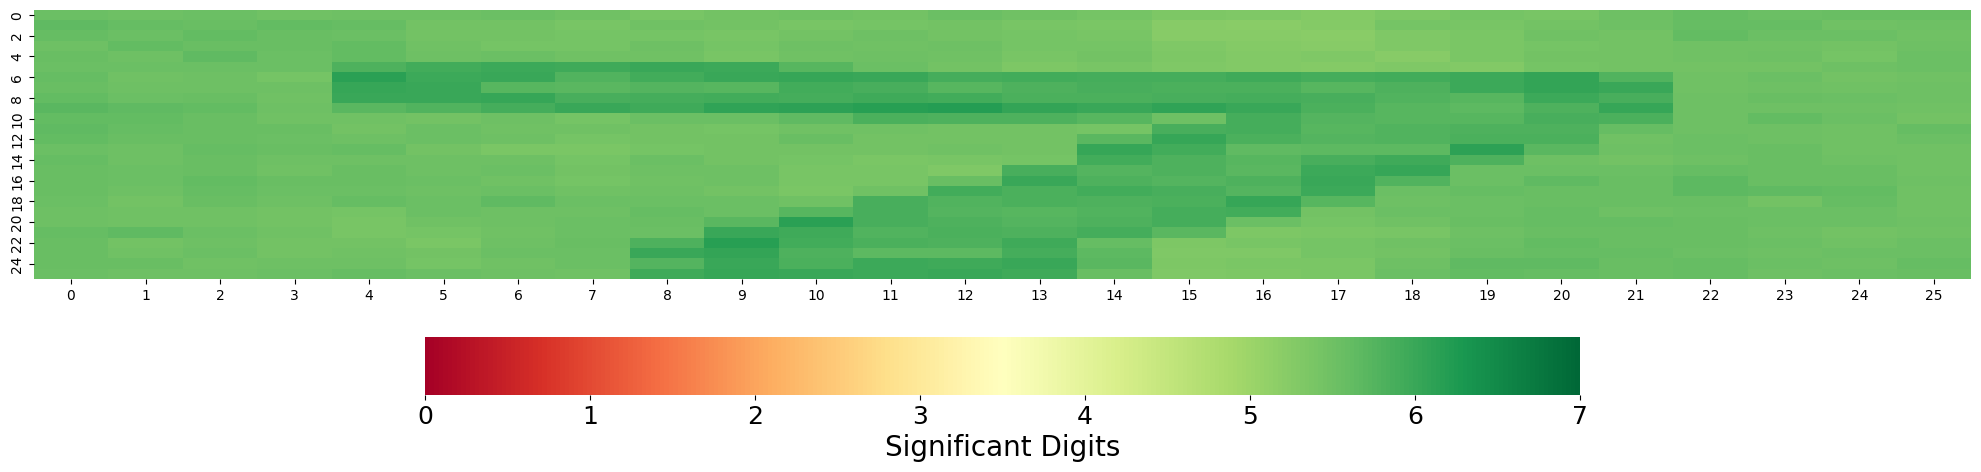

In [ ]:
for layer in ['conv1']: #, 'conv2', 'pool', 'fc1', 'fc2']:

    embed_fuzzy_ud = []


    for i in range(1,6):
        embed_fuzzy_ud.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_ud/{layer}_{i}.pkl", 'rb')) )
        
    embed_fuzzy_ud = torch.stack(embed_fuzzy_ud)
    
    fig, axes = plt.subplots(1,1, figsize=(25,5))

    #fuzzy UD
    layer_sig = sd.significant_digits(embed_fuzzy_ud.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_ud, dim=0, dtype=torch.float32),  basis=10)[0]
    g = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float32), ax=axes, cmap='RdYlGn', vmin=0, vmax=7, cbar=True, cbar_kws={"orientation": "horizontal"})
   
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)  # Set the size of the colorbar ticks
cbar.set_label('Significant Digits', size=20)  # Set the size of the colorbar label

plt.savefig(f'/home/inesgp/fuzzy-pytorch/MNIST_Use_Case/colorbar.pdf', bbox_inches='tight');

plt.show()


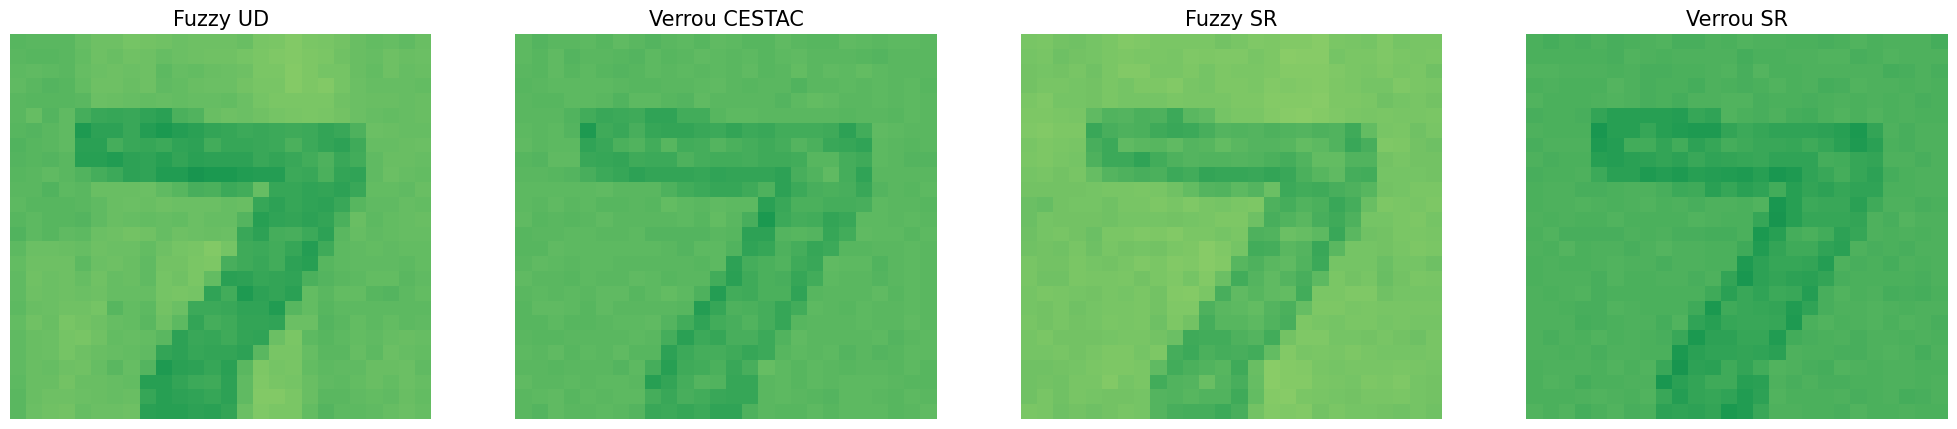

In [14]:
for layer in ['conv1', 'conv2', 'pool', 'fc1', 'fc2']:

    # embed_fuzzy_singlethread = []
    embed_fuzzy_ud = []
    embed_fuzzy_sr = []
    embed_verrou_ud = []
    embed_verrou_sr = []

    for i in range(1,6):
        # embed_fuzzy_ud.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_ud/{layer}_{i}.pkl", 'rb')) )
        # embed_fuzzy_sr.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_sr/{layer}_{i}.pkl", 'rb')) )
        embed_fuzzy_ud.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_ud_static/{layer}_{i}.pkl", 'rb')) )
        embed_fuzzy_sr.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_sr_static/{layer}_{i}.pkl", 'rb')) )
        embed_verrou_ud.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/verrou_ud_trace/{layer}_{i}.pkl", 'rb')) )
        embed_verrou_sr.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/verrou_sr_trace/{layer}_{i}.pkl", 'rb')) )

    embed_fuzzy_ud = torch.stack(embed_fuzzy_ud)
    embed_fuzzy_sr = torch.stack(embed_fuzzy_sr)
    embed_verrou_ud = torch.stack(embed_verrou_ud)
    embed_verrou_sr = torch.stack(embed_verrou_sr)

    fig, axes = plt.subplots(1,4, figsize=(25,5))

    if 'fc' in layer: 
        #fuzzy UD 
        layer_sig = sd.significant_digits(embed_fuzzy_ud.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_ud, dim=0, dtype=torch.float32),  basis=10)
        g = sns.heatmap(np.expand_dims(layer_sig[0], axis=0), ax=axes[0], cmap='RdYlGn', vmin=0, vmax=7, )
        g.set_yticks([]), g.set_xticks([]), g.set_title('Fuzzy UD')
        #fuzzy SR 
        layer_sig = sd.significant_digits(embed_fuzzy_sr.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_sr, dim=0, dtype=torch.float32),  basis=10)
        g = sns.heatmap(np.expand_dims(layer_sig[0], axis=0), ax=axes[2], cmap='RdYlGn', vmin=0, vmax=7)
        g.set_yticks([]), g.set_xticks([]), g.set_title('Fuzzy SR')
        #verrou UD
        layer_sig = sd.significant_digits(embed_verrou_ud.type(dtype=torch.float32), reference=torch.mean(embed_verrou_ud, dim=0, dtype=torch.float32),  basis=10)
        g = sns.heatmap(np.expand_dims(layer_sig[0], axis=0), ax=axes[1], cmap='RdYlGn', vmin=0, vmax=7)
        g.set_yticks([]), g.set_xticks([]), g.set_title('Verrou CESTAC')
        #verrou SR
        layer_sig = sd.significant_digits(embed_verrou_ud.type(dtype=torch.float32), reference=torch.mean(embed_verrou_ud, dim=0, dtype=torch.float32),  basis=10)
        g = sns.heatmap(np.expand_dims(layer_sig[0], axis=0), ax=axes[3], cmap='RdYlGn', vmin=0, vmax=7)
        g.set_yticks([]), g.set_xticks([]), g.set_title('Verrou SR')
    
    else:
        #fuzzy UD
        layer_sig = sd.significant_digits(embed_fuzzy_ud.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_ud, dim=0, dtype=torch.float32),  basis=10)[0]
        g = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float32), ax=axes[0], cmap='RdYlGn', vmin=0, vmax=7, cbar=False)
        g.set_yticks([]), g.set_xticks([]), g.set_title('Fuzzy UD', fontsize=15)
        #fuzzy SR
        layer_sig = sd.significant_digits(embed_fuzzy_sr.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_sr, dim=0, dtype=torch.float32),  basis=10)[0]
        g = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float32), ax=axes[2], cmap='RdYlGn', vmin=0, vmax=7, cbar=False)
        g.set_yticks([]), g.set_xticks([]), g.set_title('Fuzzy SR', fontsize=15)
        #verrou UD
        layer_sig = sd.significant_digits(embed_verrou_ud.type(dtype=torch.float32), reference=torch.mean(embed_verrou_ud, dim=0, dtype=torch.float32),  basis=10)[0]
        g = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float32), ax=axes[1], cmap='RdYlGn', vmin=0, vmax=7, cbar=False)
        g.set_yticks([]), g.set_xticks([]), g.set_title('Verrou CESTAC', fontsize=15)
        #verrou SR
        layer_sig = sd.significant_digits(embed_verrou_sr.type(dtype=torch.float32), reference=torch.mean(embed_verrou_sr, dim=0, dtype=torch.float32),  basis=10)[0]
        g = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float32), ax=axes[3], cmap='RdYlGn', vmin=0, vmax=7, cbar=False)
        g.set_yticks([]), g.set_xticks([]), g.set_title('Verrou SR', fontsize=15)
        break
        
    # axes[0].set_title(f"{layer} Fuzzy Single Threaded")
    # axes[1].set_title(f"{layer} Verrou")
    # break

plt.savefig(f'/home/inesgp/fuzzy-pytorch/MNIST_Use_Case/mnist_embeddings.pdf', bbox_inches='tight');
plt.show()

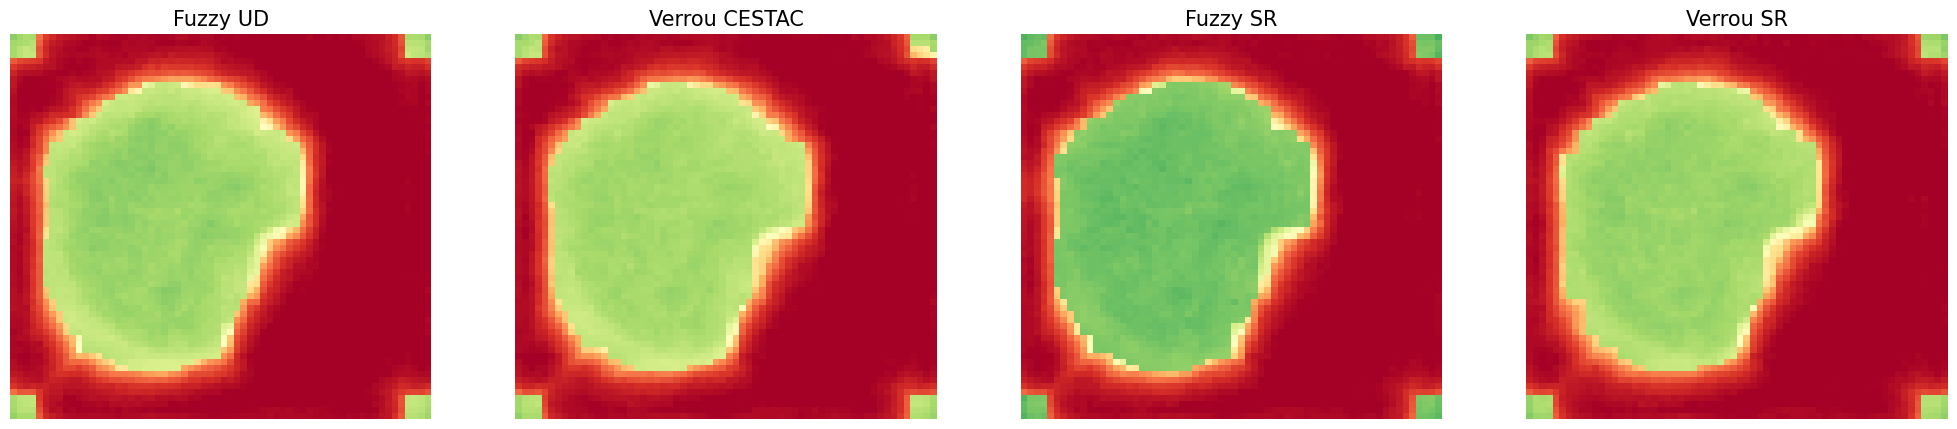

In [12]:
embed_verrou_ud = []
embed_verrou_sr = []
embed_fuzzy_ud = []
embed_fuzzy_sr = []
embed = []

for i in range(1,6):
    embed_verrou_ud.append( pickle.load(open(f'/home/inesgp/verrou_fastsurfer/0025531_embeddings/verrou_ud/sagittal_decoder_output3_{i}.pkl', 'rb')).squeeze() )
    embed_verrou_sr.append( pickle.load(open(f'/home/inesgp/verrou_fastsurfer/0025531_embeddings/verrou_sr/sagittal_decoder_output3_{i}.pkl', 'rb')).squeeze() )
    # embed_fuzzy_ud.append( pickle.load(open(f'/home/inesgp/verrou_fastsurfer/0025531_embeddings/fuzzy_ud/sagittal_decoder_output3_{i}.pkl', 'rb')).squeeze() )
    # embed_fuzzy_sr.append( pickle.load(open(f'/home/inesgp/verrou_fastsurfer/0025531_embeddings/fuzzy_sr/sagittal_decoder_output3_{i}.pkl', 'rb')).squeeze() )
    embed_fuzzy_ud.append( pickle.load(open(f'/home/inesgp/verrou_fastsurfer/0025531_embeddings/fuzzy_ud_static/sagittal_decoder_output3_{i}.pkl', 'rb')).squeeze() )
    embed_fuzzy_sr.append( pickle.load(open(f'/home/inesgp/verrou_fastsurfer/0025531_embeddings/fuzzy_sr_static/sagittal_decoder_output3_{i}.pkl', 'rb')).squeeze() )

embed_verrou_ud = np.array(embed_verrou_ud)
embed_verrou_sr = np.array(embed_verrou_sr)
embed_fuzzy_ud = np.array(embed_fuzzy_ud)
embed_fuzzy_sr = np.array(embed_fuzzy_sr)

fig, axes = plt.subplots(1, 4, figsize=(25,5))

layer_sig = sd.significant_digits(embed_fuzzy_ud, reference=np.mean(embed_fuzzy_ud, axis=0, dtype=np.float64), basis=10, dtype=np.float64)
gc = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float64), ax=axes[0], vmin=0, vmax=7, cmap='RdYlGn', cbar=False)
gc.set_yticks([]), gc.set_xticks([]), gc.set_title('Fuzzy UD', fontsize=15)
# gc.set_title(f"Fuzzy UD\nSignificant Digits\nMax: {np.max(layer_sig):.2f} and Min: {np.min(layer_sig):.2f}")

layer_sig = sd.significant_digits(embed_fuzzy_sr, reference=np.mean(embed_fuzzy_sr, axis=0, dtype=np.float64), basis=10, dtype=np.float64)
gc = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float64), ax=axes[2], vmin=0, vmax=7, cmap='RdYlGn', cbar=False)
gc.set_yticks([]), gc.set_xticks([]), gc.set_title('Fuzzy SR', fontsize=15)
# gc.set_title(f"Fuzzy SR\nSignificant Digits\nMax: {np.max(layer_sig):.2f} and Min: {np.min(layer_sig):.2f}")


layer_sig = sd.significant_digits(embed_verrou_ud, reference=np.mean(embed_verrou_ud, axis=0, dtype=np.float64), basis=10, dtype=np.float64)
gc = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float64), ax=axes[1], vmin=0, vmax=7, cmap='RdYlGn', cbar=False)
gc.set_yticks([]), gc.set_xticks([]), gc.set_title('Verrou CESTAC', fontsize=15)
# gc.set_title(f"Verrou UD\nSignificant Digits\nMax: {np.max(layer_sig):.2f} and Min: {np.min(layer_sig):.2f}")

layer_sig = sd.significant_digits(embed_verrou_sr, reference=np.mean(embed_verrou_sr, axis=0, dtype=np.float64), basis=10, dtype=np.float64)
gc = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float64), ax=axes[3], vmin=0, vmax=7, cmap='RdYlGn', cbar=False)
gc.set_yticks([]), gc.set_xticks([]), gc.set_title('Verrou SR', fontsize=15)
# gc.set_title(f"Verrou SR\nSignificant Digits\nMax: {np.max(layer_sig):.2f} and Min: {np.min(layer_sig):.2f}")

plt.savefig(f'/home/inesgp/fuzzy-pytorch/FastSurfer_Use_Case/fastsurfer_embeddings.pdf', bbox_inches='tight');


## FastSurfer Variability

### Dice Scores
* Calculated using Freesurfer v7.3.1 [```mri_seg_overlap```](https://surfer.nmr.mgh.harvard.edu/fswiki/mri_overlap)

In [2]:
def pad_list(input_list):
    # Check if the length of the list is less than 10
    while len(input_list) < 10:
        input_list.append(np.nan)  # Append NaN until the length is 10
    return input_list


def dice_score_aggregator(file_dir):

    names = {
        "ID": "int",
        "Label name": "str",
        "Red": "int",
        "Green": "int",
        "Blue": "int",
        "Alpha": "int",
    }

    df = pd.read_csv(
        '/home/inesgp/verrou_fastsurfer/FreeSurferColorLUT.txt',
        sep='\s+',
        index_col=0,
        skip_blank_lines=True,
        comment="#",
        header=None,
        names=names.keys(),
        dtype=names,
    )

    df['ID'] = df.index
    df['ID'] = df['ID'].astype(str)

    name_scheme = df.set_index('ID')['Label name'].to_dict()



    aggregated_data_min = {}
    # for sub in ['0003002', '0025011', '0025350', '0025531']:
    for sub in ['0003002', '0025011', '0025248', '0025350', '0025531']:
        aggregated_data = {}

        aggregated_data_min[sub] = {}

        n=5
        for i in range(1, n + 1):
            for j in range(i, n + 1):
                if i == j: continue
                # if i ==4 and j==5: continue
                f = open(f"{file_dir}{sub}_{i}_{j}.json", 'r')
                data = json.load(f)

                # print(data['measures']['dice']['labels'])
                # print(data['names'])

                # Aggregate the values from data['measures']['dice']['labels']
                labels = data['measures']['dice']['labels']
                if labels:
                    for label, dice_scores in labels.items():
                        # If the label is not already in the aggregated_data, initialize it as an empty list
                        if label not in aggregated_data:
                            aggregated_data[label] = []

                        # Append the value to the list for this label
                        aggregated_data[label].append(dice_scores)

                        # if label == '47': print(label, sub, i, j)

        # for i in aggregated_data:
        #     if len(aggregated_data[i]) != 10: aggregated_data[i] = pad_list(aggregated_data[i])
        #     # print( len(aggregated_data[i]), i )

        df = pd.DataFrame(aggregated_data)
        df = df.rename(columns=name_scheme)
        
        for col in df.columns:
            aggregated_data_min[sub][col] = [ df[col].min() ]


    dice_df = pd.DataFrame([])
    for sub in aggregated_data_min.keys():
        df = pd.DataFrame(aggregated_data_min[sub])
        dice_df = pd.concat([dice_df, df])
        dice_df = dice_df.rename(index={0:f"sub-{sub}"})

    dice_df['subjectID'] = dice_df.index

    # dice_df = dice_df.drop('subjectID', axis=1)

    dice_df = dice_df.reset_index(drop=True)
    dice_df = dice_df.fillna(0)

    return dice_df

# fuzzy_ud_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/fuzzy_ud/')
# fuzzy_ud_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/fuzzy_ud/full_brain/') #fragmented brain
# fuzzy_ud_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/fuzzy_ud_noargmax/full_brain/') #dynamic version
fuzzy_ud_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/fuzzy_ud_blacklist/full_brain/') #static version
# fuzzy_sr_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/fuzzy_sr/')
# fuzzy_sr_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/fuzzy_sr/full_brain/') #dynamic version
fuzzy_sr_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/fuzzy_sr_blacklist/full_brain/') #static version
# verrou_ud_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/verrou_ud/')
verrou_ud_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/verrou_ud/full_brain/')
# verrou_sr_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/verrou_sr/')
verrou_sr_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/verrou_sr/full_brain/')
default_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/ieee/')


In [4]:
verrou_sr_dice_df.to_csv('/home/inesgp/fuzzy-pytorch/FastSurfer_Use_Case/verrou_sr_min_dice_scores.csv', index=False)
verrou_ud_dice_df.to_csv('/home/inesgp/fuzzy-pytorch/FastSurfer_Use_Case/verrou_ud_min_dice_scores.csv', index=False)
fuzzy_sr_dice_df.to_csv('/home/inesgp/fuzzy-pytorch/FastSurfer_Use_Case/fuzzy_sr_min_dice_scores.csv', index=False)
fuzzy_ud_dice_df.to_csv('/home/inesgp/fuzzy-pytorch/FastSurfer_Use_Case/fuzzy_ud_min_dice_scores.csv', index=False)
default_dice_df.to_csv('/home/inesgp/fuzzy-pytorch/FastSurfer_Use_Case/ieee_min_dice_scores.csv', index=False)

In [3]:
# STATIC VERSIONS OF FUZZY
long_df = fuzzy_ud_dice_df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')
print(f"fuzzy ud {long_df['Sorensen Dice Scores'].mean()} {long_df['Sorensen Dice Scores'].std()}")
long_df = fuzzy_sr_dice_df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')
print(f"fuzzy sr {long_df['Sorensen Dice Scores'].mean()} {long_df['Sorensen Dice Scores'].std()}")
long_df = verrou_ud_dice_df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')
print(f"verrou ud {long_df['Sorensen Dice Scores'].mean()} {long_df['Sorensen Dice Scores'].std()}")
long_df = verrou_sr_dice_df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')
print(f"verrou sr {long_df['Sorensen Dice Scores'].mean()} {long_df['Sorensen Dice Scores'].std()}")


fuzzy ud 0.9999499142688071 0.00015656733634842763
fuzzy sr 0.9999866312486217 0.00010994383546026506
verrou ud 0.9999671402979678 9.772094168463242e-05
verrou sr 0.9999674514382648 0.00013978648279945906


In [ ]:
#DYNAMIC VERSIONS OF FUZZY
long_df = fuzzy_ud_dice_df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')
print(f"fuzzy ud {long_df['Sorensen Dice Scores'].mean()} {long_df['Sorensen Dice Scores'].std()}")
long_df = fuzzy_sr_dice_df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')
print(f"fuzzy sr {long_df['Sorensen Dice Scores'].mean()} {long_df['Sorensen Dice Scores'].std()}")
long_df = verrou_ud_dice_df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')
print(f"verrou ud {long_df['Sorensen Dice Scores'].mean()} {long_df['Sorensen Dice Scores'].std()}")
long_df = verrou_sr_dice_df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')
print(f"verrou sr {long_df['Sorensen Dice Scores'].mean()} {long_df['Sorensen Dice Scores'].std()}")


fuzzy ud 0.9999638841325003 0.00015236080232755646
fuzzy sr 0.9999704218413549 0.00013533210848891062
verrou ud 0.9999671402979678 9.772094168463242e-05
verrou sr 0.9999674514382648 0.00013978648279945906


**UD/SR with Argmax, log, exp being Blacklisted (Static version)**

In [12]:
def graph_dice(df, fig, color, symbol, label, col=1, lower=True, legend=True, rois_subset=None):

    long_df = df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')
    # List of all ROIs
    full_list_of_rois = [
        'Left-Thalamus', 'Left-Caudate', 'Left-Putamen', '3rd-Ventricle', 'Brain-Stem', 'Left-Hippocampus', 
        'Left-Cerebral-White-Matter', 'CSF', 'Left-Accumbens-area', 'Left-VentralDC', 'Left-Cerebral-Cortex', 
        'Left-choroid-plexus', 'Left-Lateral-Ventricle', 'Right-Cerebral-White-Matter', 'Right-Lateral-Ventricle', 
        'Right-Inf-Lat-Vent', 'Right-Thalamus', 'Right-Caudate', 'Right-Hippocampus', 'Right-VentralDC', 
        'Right-choroid-plexus', 'Left-Cerebellum-White-Matter', 'WM-hypointensities', 'Left-Cerebellum-Cortex', 
        'Right-Cerebral-Cortex', '4th-Ventricle', 'Left-Pallidum', 'Left-Amygdala', 'Right-Cerebellum-White-Matter', 
        'Right-Cerebellum-Cortex', 'Left-Inf-Lat-Vent', 'Right-Putamen', 'Right-Pallidum', 'Right-Amygdala',
        'Right-Accumbens-area'
    ]

    all_rois = rois_subset if rois_subset is not None else full_list_of_rois    


    if lower:

        # Align Sorensen Dice Scores with all ROIs, filling missing values with NaN
        x_values = (
            long_df[long_df['Sorensen Dice Scores'] <= 0.8]
            .groupby('ROI')['Sorensen Dice Scores']
            .min()  # Or use another aggregation function like `.max()` or `.first()`
        )

        # Initialize aligned_scores with NaN
        aligned_scores = pd.Series(index=all_rois, data=np.nan)
        # Reindex x_values to match aligned_scores and update
        aligned_scores.update(x_values.reindex(aligned_scores.index))

        jitter_strength = 0.3  # Adjust this value to control jitter amount
        jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(aligned_scores.values))
        y_numerical, categories = pd.factorize(aligned_scores.index)  # Convert ROI to numerical indices

        y_with_jitter = y_numerical + jitter


        # df = pd.DataFrame({'ROI': aligned_scores.index, 'Sorensen Dice Score': aligned_scores.values})
        df = pd.DataFrame({'ROI': y_with_jitter, 'Sorensen Dice Score': aligned_scores.values })

        fig.add_trace(
            go.Scatter(
                x=df['Sorensen Dice Score'],
                y=df['ROI'],
                mode='markers',
                marker=dict(
                    color=color,
                    opacity=0.75,
                    size=10,
                    symbol=symbol,
                ),
                name=label,
                showlegend=legend,
            ),
            row=1, col=col
        )

        # Update y-axis to display ROI categories
        fig.update_yaxes(
            tickvals=y_numerical,  # Original numerical indices
            ticktext=categories,  # Corresponding category names
            tickfont=dict(size=15)  # Set the font size for y-axis ticks
        )

    else:

        # Align Sorensen Dice Scores with all ROIs, filling missing values with NaN
        x_values = (
            long_df
            .groupby('ROI')['Sorensen Dice Scores']
            .min()  # Or use another aggregation function like `.max()` or `.first()`
        )

        # Initialize aligned_scores with NaN
        aligned_scores = pd.Series(index=all_rois, data=np.nan)
        # Reindex x_values to match aligned_scores and update
        aligned_scores.update(x_values.reindex(aligned_scores.index))

        jitter_strength = 0.3  # Adjust this value to control jitter amount
        jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(aligned_scores.values))
        y_numerical, categories = pd.factorize(aligned_scores.index)  # Convert ROI to numerical indices

        y_with_jitter = y_numerical + jitter


        df = pd.DataFrame({'ROI': y_with_jitter, 'Sorensen Dice Score': aligned_scores.values})

        fig.add_trace(
            go.Scatter(
                x=df['Sorensen Dice Score'],
                y=df['ROI'],
                mode='markers',
                marker=dict(
                    color=color,
                    opacity=0.75,
                    size=10,
                    symbol=symbol,
                ),
                name=label,
                showlegend=legend,
            ),
            row=1, col=col
        )

        # Update y-axis to display ROI categories
        fig.update_yaxes(
            row=1, col=col,
            tickvals=y_numerical,  # Original numerical indices
            ticktext=categories,  # Corresponding category names
            tickfont=dict(size=20),  # Set the font size for y-axis ticks
            range=[-0.5, max(y_numerical) + 0.5]  # Set fixed range to prevent extra space
        )


fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.25)

all_rois = sorted([ 'Left-Thalamus', 'Left-Caudate', 'Left-Putamen', '3rd-Ventricle', 'Brain-Stem', 'Left-Hippocampus', 
        'Left-Cerebral-White-Matter', 'CSF', 'Left-Accumbens-area', 'Left-VentralDC', 'Left-Cerebral-Cortex', 
        'Left-choroid-plexus', 'Left-Lateral-Ventricle', 'Right-Cerebral-White-Matter', 'Right-Lateral-Ventricle', 
        'Right-Inf-Lat-Vent', 'Right-Thalamus', 'Right-Caudate', 'Right-Hippocampus', 'Right-VentralDC', 
        'Right-choroid-plexus', 'Left-Cerebellum-White-Matter', 'WM-hypointensities', 'Left-Cerebellum-Cortex', 
        'Right-Cerebral-Cortex', '4th-Ventricle', 'Left-Pallidum', 'Left-Amygdala', 'Right-Cerebellum-White-Matter', 
        'Right-Cerebellum-Cortex', 'Left-Inf-Lat-Vent', 'Right-Putamen', 'Right-Pallidum', 'Right-Amygdala',
        'Right-Accumbens-area' ])  # full list  
split_index = len(all_rois) // 2  
all_rois_left = all_rois[:split_index]  
all_rois_right = all_rois[split_index:]


graph_dice(fuzzy_ud_dice_df, fig, color=px.colors.qualitative.Plotly[0], symbol='diamond', label='Fuzzy UD', lower=False, col=1, rois_subset=all_rois_left)
graph_dice(fuzzy_ud_dice_df, fig, color=px.colors.qualitative.Plotly[0], symbol='diamond', label='Fuzzy UD', lower=False, col=2, legend=False, rois_subset=all_rois_right)
graph_dice(fuzzy_sr_dice_df, fig, color=px.colors.qualitative.Plotly[0], symbol='triangle-up', label='Fuzzy SR', lower=False, col=1, rois_subset=all_rois_left)
graph_dice(fuzzy_sr_dice_df, fig, color=px.colors.qualitative.Plotly[0], symbol='triangle-up', label='Fuzzy SR', lower=False, col=2, legend=False, rois_subset=all_rois_right)
graph_dice(verrou_ud_dice_df, fig, color= px.colors.qualitative.Plotly[4], symbol='x', label='Verrou CESTAC', lower=False, col=1, rois_subset=all_rois_left)
graph_dice(verrou_ud_dice_df, fig, color= px.colors.qualitative.Plotly[4], symbol='x', label='Verrou CESTAC', lower=False, col=2, legend=False, rois_subset=all_rois_right)
graph_dice(verrou_sr_dice_df, fig, color= px.colors.qualitative.Plotly[4], symbol='triangle-up', label='Verrou SR', lower=False, col=1, rois_subset=all_rois_left)
graph_dice(verrou_sr_dice_df, fig, color= px.colors.qualitative.Plotly[4], symbol='triangle-up', label='Verrou SR', lower=False, col=2, legend=False, rois_subset=all_rois_right)


common_x_range = [0.9985, 1.00002]  # or your desired Dice Score range
fig.update_xaxes(range=common_x_range, row=1, col=1)
fig.update_xaxes(range=common_x_range, row=1, col=2)

# fig.update_xaxes(
#     title_text="Sorensen Dice Scores", 
#     tickfont=dict(size=20),  # Set a consistent font size for all ticks
#     title_font=dict(size=20),  # Set the font size of the y-axis label
#     )


# Layout adjustments
fig.update_layout(
    width=1500,
    height=800,
    annotations=[
        dict(
            text="Sorensen Dice Scores",
            x=0.5,
            y=-0.03,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=20),
            xanchor='center',
            yanchor='top'
        )
    ],
    showlegend=True,  # Show the legend
    margin=dict(l=10, r=10, t=5, b=50),
    legend=dict(
        orientation="h",  # Set legend to horizontal orientation
        yanchor="bottom",
        y=1.0,  # Position the legend above the figure
        xanchor="center",
        x=0.5,  # Center the legend horizontally
        font=dict(size=20),  # Adjust legend font size
    ),
)

fig.update_xaxes(
    tickfont=dict(size=20),  # Increase tick size
)

# fig.write_image('/home/inesgp/verrou_fastsurfer/fastsurfer_min_dice_noargmax.pdf', engine="kaleido", format='pdf')
fig.write_image('/home/inesgp/verrou_fastsurfer/fastsurfer_min_dice_noargmax.svg', engine="kaleido", )


# Show the plot
fig.show()


**UD with Argmax being Blacklisted (Dynamic version)**

In [7]:
def graph_dice(df, fig, color, symbol, label, lower=True, legend=True):

    long_df = df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')

    # List of all ROIs
    all_rois = [
        'Left-Thalamus', 'Left-Caudate', 'Left-Putamen', '3rd-Ventricle', 'Brain-Stem', 'Left-Hippocampus', 
        'Left-Cerebral-White-Matter', 'CSF', 'Left-Accumbens-area', 'Left-VentralDC', 'Left-Cerebral-Cortex', 
        'Left-choroid-plexus', 'Left-Lateral-Ventricle', 'Right-Cerebral-White-Matter', 'Right-Lateral-Ventricle', 
        'Right-Inf-Lat-Vent', 'Right-Thalamus', 'Right-Caudate', 'Right-Hippocampus', 'Right-VentralDC', 
        'Right-choroid-plexus', 'Left-Cerebellum-White-Matter', 'WM-hypointensities', 'Left-Cerebellum-Cortex', 
        'Right-Cerebral-Cortex', '4th-Ventricle', 'Left-Pallidum', 'Left-Amygdala', 'Right-Cerebellum-White-Matter', 
        'Right-Cerebellum-Cortex', 'Left-Inf-Lat-Vent', 'Right-Putamen', 'Right-Pallidum', 'Right-Amygdala',
        'Right-Accumbens-area'
    ]

    if lower:

        # Align Sorensen Dice Scores with all ROIs, filling missing values with NaN
        x_values = (
            long_df[long_df['Sorensen Dice Scores'] <= 0.8]
            .groupby('ROI')['Sorensen Dice Scores']
            .mean()  # Or use another aggregation function like `.max()` or `.first()`
        )

        # Initialize aligned_scores with NaN
        aligned_scores = pd.Series(index=all_rois, data=np.nan)
        # Reindex x_values to match aligned_scores and update
        aligned_scores.update(x_values.reindex(aligned_scores.index))

        jitter_strength = 0.3  # Adjust this value to control jitter amount
        jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(aligned_scores.values))
        y_numerical, categories = pd.factorize(aligned_scores.index)  # Convert ROI to numerical indices

        y_with_jitter = y_numerical + jitter


        # df = pd.DataFrame({'ROI': aligned_scores.index, 'Sorensen Dice Score': aligned_scores.values})
        df = pd.DataFrame({'ROI': y_with_jitter, 'Sorensen Dice Score': aligned_scores.values })

        fig.add_trace(
            go.Scatter(
                x=df['Sorensen Dice Score'],
                y=df['ROI'],
                mode='markers',
                marker=dict(
                    color=color,
                    opacity=0.75,
                    size=10,
                    symbol=symbol,
                ),
                name=label,
                showlegend=legend,
            ),
            row=1, col=1
        )

        # Update y-axis to display ROI categories
        fig.update_yaxes(
            tickvals=y_numerical,  # Original numerical indices
            ticktext=categories,  # Corresponding category names
            tickfont=dict(size=15)  # Set the font size for y-axis ticks
        )

    else:

        # Align Sorensen Dice Scores with all ROIs, filling missing values with NaN
        x_values = (
            long_df
            .groupby('ROI')['Sorensen Dice Scores']
            .mean()  # Or use another aggregation function like `.max()` or `.first()`
        )

        # Initialize aligned_scores with NaN
        aligned_scores = pd.Series(index=all_rois, data=np.nan)
        # Reindex x_values to match aligned_scores and update
        aligned_scores.update(x_values.reindex(aligned_scores.index))

        jitter_strength = 0.3  # Adjust this value to control jitter amount
        jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(aligned_scores.values))
        y_numerical, categories = pd.factorize(aligned_scores.index)  # Convert ROI to numerical indices

        y_with_jitter = y_numerical + jitter


        df = pd.DataFrame({'ROI': y_with_jitter, 'Sorensen Dice Score': aligned_scores.values})

        fig.add_trace(
            go.Scatter(
                x=df['Sorensen Dice Score'],
                y=df['ROI'],
                mode='markers',
                marker=dict(
                    color=color,
                    opacity=0.75,
                    size=10,
                    symbol=symbol,
                ),
                name=label,
                showlegend=legend,
            ),
            # row=1, col=2
        )

        # Update y-axis to display ROI categories
        fig.update_yaxes(
            tickvals=y_numerical,  # Original numerical indices
            ticktext=categories,  # Corresponding category names
            tickfont=dict(size=15)  # Set the font size for y-axis ticks
        )



fig = make_subplots(rows=1, cols=1, shared_yaxes=True, horizontal_spacing=0.0)

#Harmonize colors + markers with Yohan's Harmonic figure
# color_map = {
#     "PRISM": px.colors.qualitative.Plotly[0],  # blue
#     "VERROU": px.colors.qualitative.Plotly[4],  # red
#     "CADNA": px.colors.qualitative.Plotly[2],  # green
#     "IEEE": px.colors.qualitative.Plotly[3],  # yellow
#     "IEEE": px.colors.qualitative.Plotly[8],  # purple
#     "SR": px.colors.qualitative.Plotly[5],  # purple
#     "MCA": px.colors.qualitative.Plotly[1],  #
# }

# graph_dice(fuzzy_ud_dice_df, fig, color=px.colors.qualitative.Plotly[0], symbol='diamond', label='Fuzzy UD')
graph_dice(fuzzy_ud_dice_df, fig, color=px.colors.qualitative.Plotly[0], symbol='diamond', label='Fuzzy UD', lower=False)
# graph_dice(fuzzy_sr_dice_df, fig, color=px.colors.qualitative.Plotly[0], symbol='triangle-up', label='Fuzzy SR')
graph_dice(fuzzy_sr_dice_df, fig, color=px.colors.qualitative.Plotly[0], symbol='triangle-up', label='Fuzzy SR', lower=False)
# graph_dice(verrou_ud_dice_df, fig, color= px.colors.qualitative.Plotly[4], symbol='x', label='Verrou CESTAC')
graph_dice(verrou_ud_dice_df, fig, color= px.colors.qualitative.Plotly[4], symbol='x', label='Verrou CESTAC', lower=False)
# graph_dice(verrou_sr_dice_df, fig, color= px.colors.qualitative.Plotly[4], symbol='triangle-up', label='Verrou SR', )
graph_dice(verrou_sr_dice_df, fig, color= px.colors.qualitative.Plotly[4], symbol='triangle-up', label='Verrou SR', lower=False, legend=True)
# graph_dice(default_dice_df, fig, color='red', label='IEEE')


# Update y-axis
fig.update_yaxes(
    title_text="ROI", 
    row=1, col=1,
    tickfont=dict(size=16),  # Set a consistent font size for all ticks
    title_font=dict(size=18),  # Set the font size of the y-axis label
    automargin=True,  # Ensure enough margin for tick labels
    range=[-1,35]
    )


fig.update_xaxes(
    title_text="Sorensen Dice Scores", 
    tickfont=dict(size=16),  # Set a consistent font size for all ticks
    title_font=dict(size=18),  # Set the font size of the y-axis label
    )


# Layout adjustments
fig.update_layout(
    width=800,
    height=1400,
    showlegend=True,  # Show the legend
    margin=dict(l=10, r=10, t=5, b=10),
    legend=dict(
        orientation="h",  # Set legend to horizontal orientation
        yanchor="bottom",
        y=1.0,  # Position the legend above the figure
        xanchor="center",
        x=0.5,  # Center the legend horizontally
        font=dict(size=14),  # Adjust legend font size
    ),
)



fig.write_image('/home/inesgp/verrou_fastsurfer/fastsurfer_min_dice_noargmax.pdf', engine="kaleido", format='pdf')


# Show the plot
fig.show()


**UD without Argmax being Blacklisted (Dynamic version)**

In [20]:
def graph_dice(df, fig, color, symbol, label, lower=True, legend=True):

    long_df = df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')

    # List of all ROIs
    all_rois = [
        'Left-Thalamus', 'Left-Caudate', 'Left-Putamen', '3rd-Ventricle', 'Brain-Stem', 'Left-Hippocampus', 
        'Left-Cerebral-White-Matter', 'CSF', 'Left-Accumbens-area', 'Left-VentralDC', 'Left-Cerebral-Cortex', 
        'Left-choroid-plexus', 'Left-Lateral-Ventricle', 'Right-Cerebral-White-Matter', 'Right-Lateral-Ventricle', 
        'Right-Inf-Lat-Vent', 'Right-Thalamus', 'Right-Caudate', 'Right-Hippocampus', 'Right-VentralDC', 
        'Right-choroid-plexus', 'Left-Cerebellum-White-Matter', 'WM-hypointensities', 'Left-Cerebellum-Cortex', 
        'Right-Cerebral-Cortex', '4th-Ventricle', 'Left-Pallidum', 'Left-Amygdala', 'Right-Cerebellum-White-Matter', 
        'Right-Cerebellum-Cortex', 'Left-Inf-Lat-Vent', 'Right-Putamen', 'Right-Pallidum', 'Right-Amygdala',
        'Right-Accumbens-area'
    ]

    if lower:

        # Align Sorensen Dice Scores with all ROIs, filling missing values with NaN
        x_values = (
            long_df[long_df['Sorensen Dice Scores'] <= 0.8]
            .groupby('ROI')['Sorensen Dice Scores']
            .mean()  # Or use another aggregation function like `.max()` or `.first()`
        )

        # Initialize aligned_scores with NaN
        aligned_scores = pd.Series(index=all_rois, data=np.nan)
        # Reindex x_values to match aligned_scores and update
        aligned_scores.update(x_values.reindex(aligned_scores.index))

        jitter_strength = 0.3  # Adjust this value to control jitter amount
        jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(aligned_scores.values))
        y_numerical, categories = pd.factorize(aligned_scores.index)  # Convert ROI to numerical indices

        y_with_jitter = y_numerical + jitter


        # df = pd.DataFrame({'ROI': aligned_scores.index, 'Sorensen Dice Score': aligned_scores.values})
        df = pd.DataFrame({'ROI': y_with_jitter, 'Sorensen Dice Score': aligned_scores.values })

        fig.add_trace(
            go.Scatter(
                x=df['Sorensen Dice Score'],
                y=df['ROI'],
                mode='markers',
                marker=dict(
                    color=color,
                    opacity=0.75,
                    size=10,
                    symbol=symbol,
                ),
                name=label,
                showlegend=legend,
            ),
            row=1, col=1
        )

        # Update y-axis to display ROI categories
        fig.update_yaxes(
            tickvals=y_numerical,  # Original numerical indices
            ticktext=categories,  # Corresponding category names
            tickfont=dict(size=15)  # Set the font size for y-axis ticks
        )

    else:

        # Align Sorensen Dice Scores with all ROIs, filling missing values with NaN
        x_values = (
            long_df[long_df['Sorensen Dice Scores'] >= 0.8]
            .groupby('ROI')['Sorensen Dice Scores']
            .mean()  # Or use another aggregation function like `.max()` or `.first()`
        )

        # Initialize aligned_scores with NaN
        aligned_scores = pd.Series(index=all_rois, data=np.nan)
        # Reindex x_values to match aligned_scores and update
        aligned_scores.update(x_values.reindex(aligned_scores.index))

        jitter_strength = 0.3  # Adjust this value to control jitter amount
        jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(aligned_scores.values))
        y_numerical, categories = pd.factorize(aligned_scores.index)  # Convert ROI to numerical indices

        y_with_jitter = y_numerical + jitter


        df = pd.DataFrame({'ROI': y_with_jitter, 'Sorensen Dice Score': aligned_scores.values})

        fig.add_trace(
            go.Scatter(
                x=df['Sorensen Dice Score'],
                y=df['ROI'],
                mode='markers',
                marker=dict(
                    color=color,
                    opacity=0.75,
                    size=10,
                    symbol=symbol,
                ),
                name=label,
                showlegend=False,
            ),
            row=1, col=2
        )



fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.0)

#Harmonize colors + markers with Yohan's Harmonic figure
# color_map = {
#     "PRISM": px.colors.qualitative.Plotly[0],  # blue
#     "VERROU": px.colors.qualitative.Plotly[4],  # red
#     "CADNA": px.colors.qualitative.Plotly[2],  # green
#     "IEEE": px.colors.qualitative.Plotly[3],  # yellow
#     "IEEE": px.colors.qualitative.Plotly[8],  # purple
#     "SR": px.colors.qualitative.Plotly[5],  # purple
#     "MCA": px.colors.qualitative.Plotly[1],  #
# }

graph_dice(fuzzy_ud_dice_df, fig, color=px.colors.qualitative.Plotly[0], symbol='diamond', label='Fuzzy UD')
graph_dice(fuzzy_ud_dice_df, fig, color=px.colors.qualitative.Plotly[0], symbol='diamond', label='Fuzzy UD', lower=False)
graph_dice(fuzzy_sr_dice_df, fig, color=px.colors.qualitative.Plotly[0], symbol='triangle-up', label='Fuzzy SR')
graph_dice(fuzzy_sr_dice_df, fig, color=px.colors.qualitative.Plotly[0], symbol='triangle-up', label='Fuzzy SR', lower=False)
graph_dice(verrou_ud_dice_df, fig, color= px.colors.qualitative.Plotly[4], symbol='x', label='Verrou CESTAC')
graph_dice(verrou_ud_dice_df, fig, color= px.colors.qualitative.Plotly[4], symbol='x', label='Verrou CESTAC', lower=False)
graph_dice(verrou_sr_dice_df, fig, color= px.colors.qualitative.Plotly[4], symbol='triangle-up', label='Verrou SR')
graph_dice(verrou_sr_dice_df, fig, color= px.colors.qualitative.Plotly[4], symbol='triangle-up', label='Verrou SR', lower=False, legend=True)
# graph_dice(default_dice_df, fig, color='red', label='IEEE')

# Custom tick values and labels
custom_ticks = [-0.05, 0, 0.05, 0.1, 0.995, 1, 1.05]
custom_labels = ["-0.05", "0", "...", "", "0.995", "1", "1.05"]
custom_ticks = [0.40, 0.5, 0.6, 0.65, 0.995, 1, 1.05]
custom_labels = ["0.40", "0.50", "...", "", "0.995", "1", "1.05"]

# Update x-axis for both subplots with custom ticks
fig.update_xaxes(
    tickvals=custom_ticks[:4],  # First set of ticks
    ticktext=custom_labels[:4],
    range=[0.35, 0.65],
    tickfont=dict(size=16),  # Set a consistent font size for all ticks
    title_text="",
    row=1,
    col=1
)

fig.update_xaxes(
    tickvals=custom_ticks[4:],  # Second set of ticks
    ticktext=custom_labels[4:],
    range=[0.995, 1.005],
    tickfont=dict(size=16),  # Set a consistent font size for all ticks
    title_text="",
    row=1,
    col=2
)


# Update y-axis
fig.update_yaxes(
    title_text="ROI", 
    row=1, col=1,
    tickfont=dict(size=16),  # Set a consistent font size for all ticks
    title_font=dict(size=18),  # Set the font size of the y-axis label
    automargin=True,  # Ensure enough margin for tick labels
    range=[-1,35]
    )

# Add a shared x-axis label
fig.add_annotation(
    x=0.5,
    y=-0.04,  # Adjust position for shared label (within the plot area)
    text="Sorensen Dice Scores",
    showarrow=False,
    xref="paper",
    yref="paper",
    font=dict(size=18),
)

# Layout adjustments
fig.update_layout(
    width=800,
    height=1400,
    showlegend=True,  # Show the legend
    margin=dict(l=10, r=10, t=5, b=10),
    legend=dict(
        orientation="h",  # Set legend to horizontal orientation
        yanchor="bottom",
        y=1.0,  # Position the legend above the figure
        xanchor="center",
        x=0.5,  # Center the legend horizontally
        font=dict(size=14),  # Adjust legend font size
    ),
)



fig.write_image('/home/inesgp/verrou_fastsurfer/fastsurfer_min_dice.pdf', engine="kaleido", format='pdf')


# Show the plot
fig.show()
